In [1]:
import os
import wfdb
import scipy
import pickle
import imageio
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import neurokit2 as nk
import scipy.io as sci
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.figsize'] = (16, 10)

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms

from tqdm import tqdm
from PIL import Image
from scipy import linalg, sparse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score
)

from scipy.signal import spectrogram, cwt, ricker

In [2]:
def canvas2rgb_array(canvas):
    canvas.draw()
    buf = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    ncols, nrows = canvas.get_width_height()
    scale = round(np.sqrt(buf.size / 4 / nrows / ncols))
    return buf.reshape(scale * nrows, scale * ncols, 4)

def spectrogram_to_img(frequencies, times, Sxx):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    for ax in fig.get_axes():
        ax.axis('off')

    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('')
    for ax in fig.get_axes():
        ax.set_title('')

    img = canvas2rgb_array(fig.canvas)[..., :3]

    return img

def cwt_to_img(cwt_result, time):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.imshow(np.abs(cwt_result), aspect='auto', extent=[0, time[-1], 1, 31], cmap='viridis', interpolation="bilinear")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    for ax in fig.get_axes():
        ax.axis('off')

    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('')
    for ax in fig.get_axes():
        ax.set_title('')

    img = canvas2rgb_array(fig.canvas)[..., :3]
    return img

## Data preparation

In [3]:
sorted(os.listdir("training2017"))[:4]

['A00001.hea', 'A00001.mat', 'A00002.hea', 'A00002.mat']

In [4]:
SAMPLING_RATE = 300 # Hz

In [5]:
basepath = "training2017"
first_rec = os.path.join(basepath, "A00001.mat")
firest_rec_header = os.path.join(basepath, "A00001")

In [6]:
rec = sci.loadmat(first_rec)["val"][0]
rec.shape

(9000,)

Text(0.5, 1.0, 'ECG Signal example')

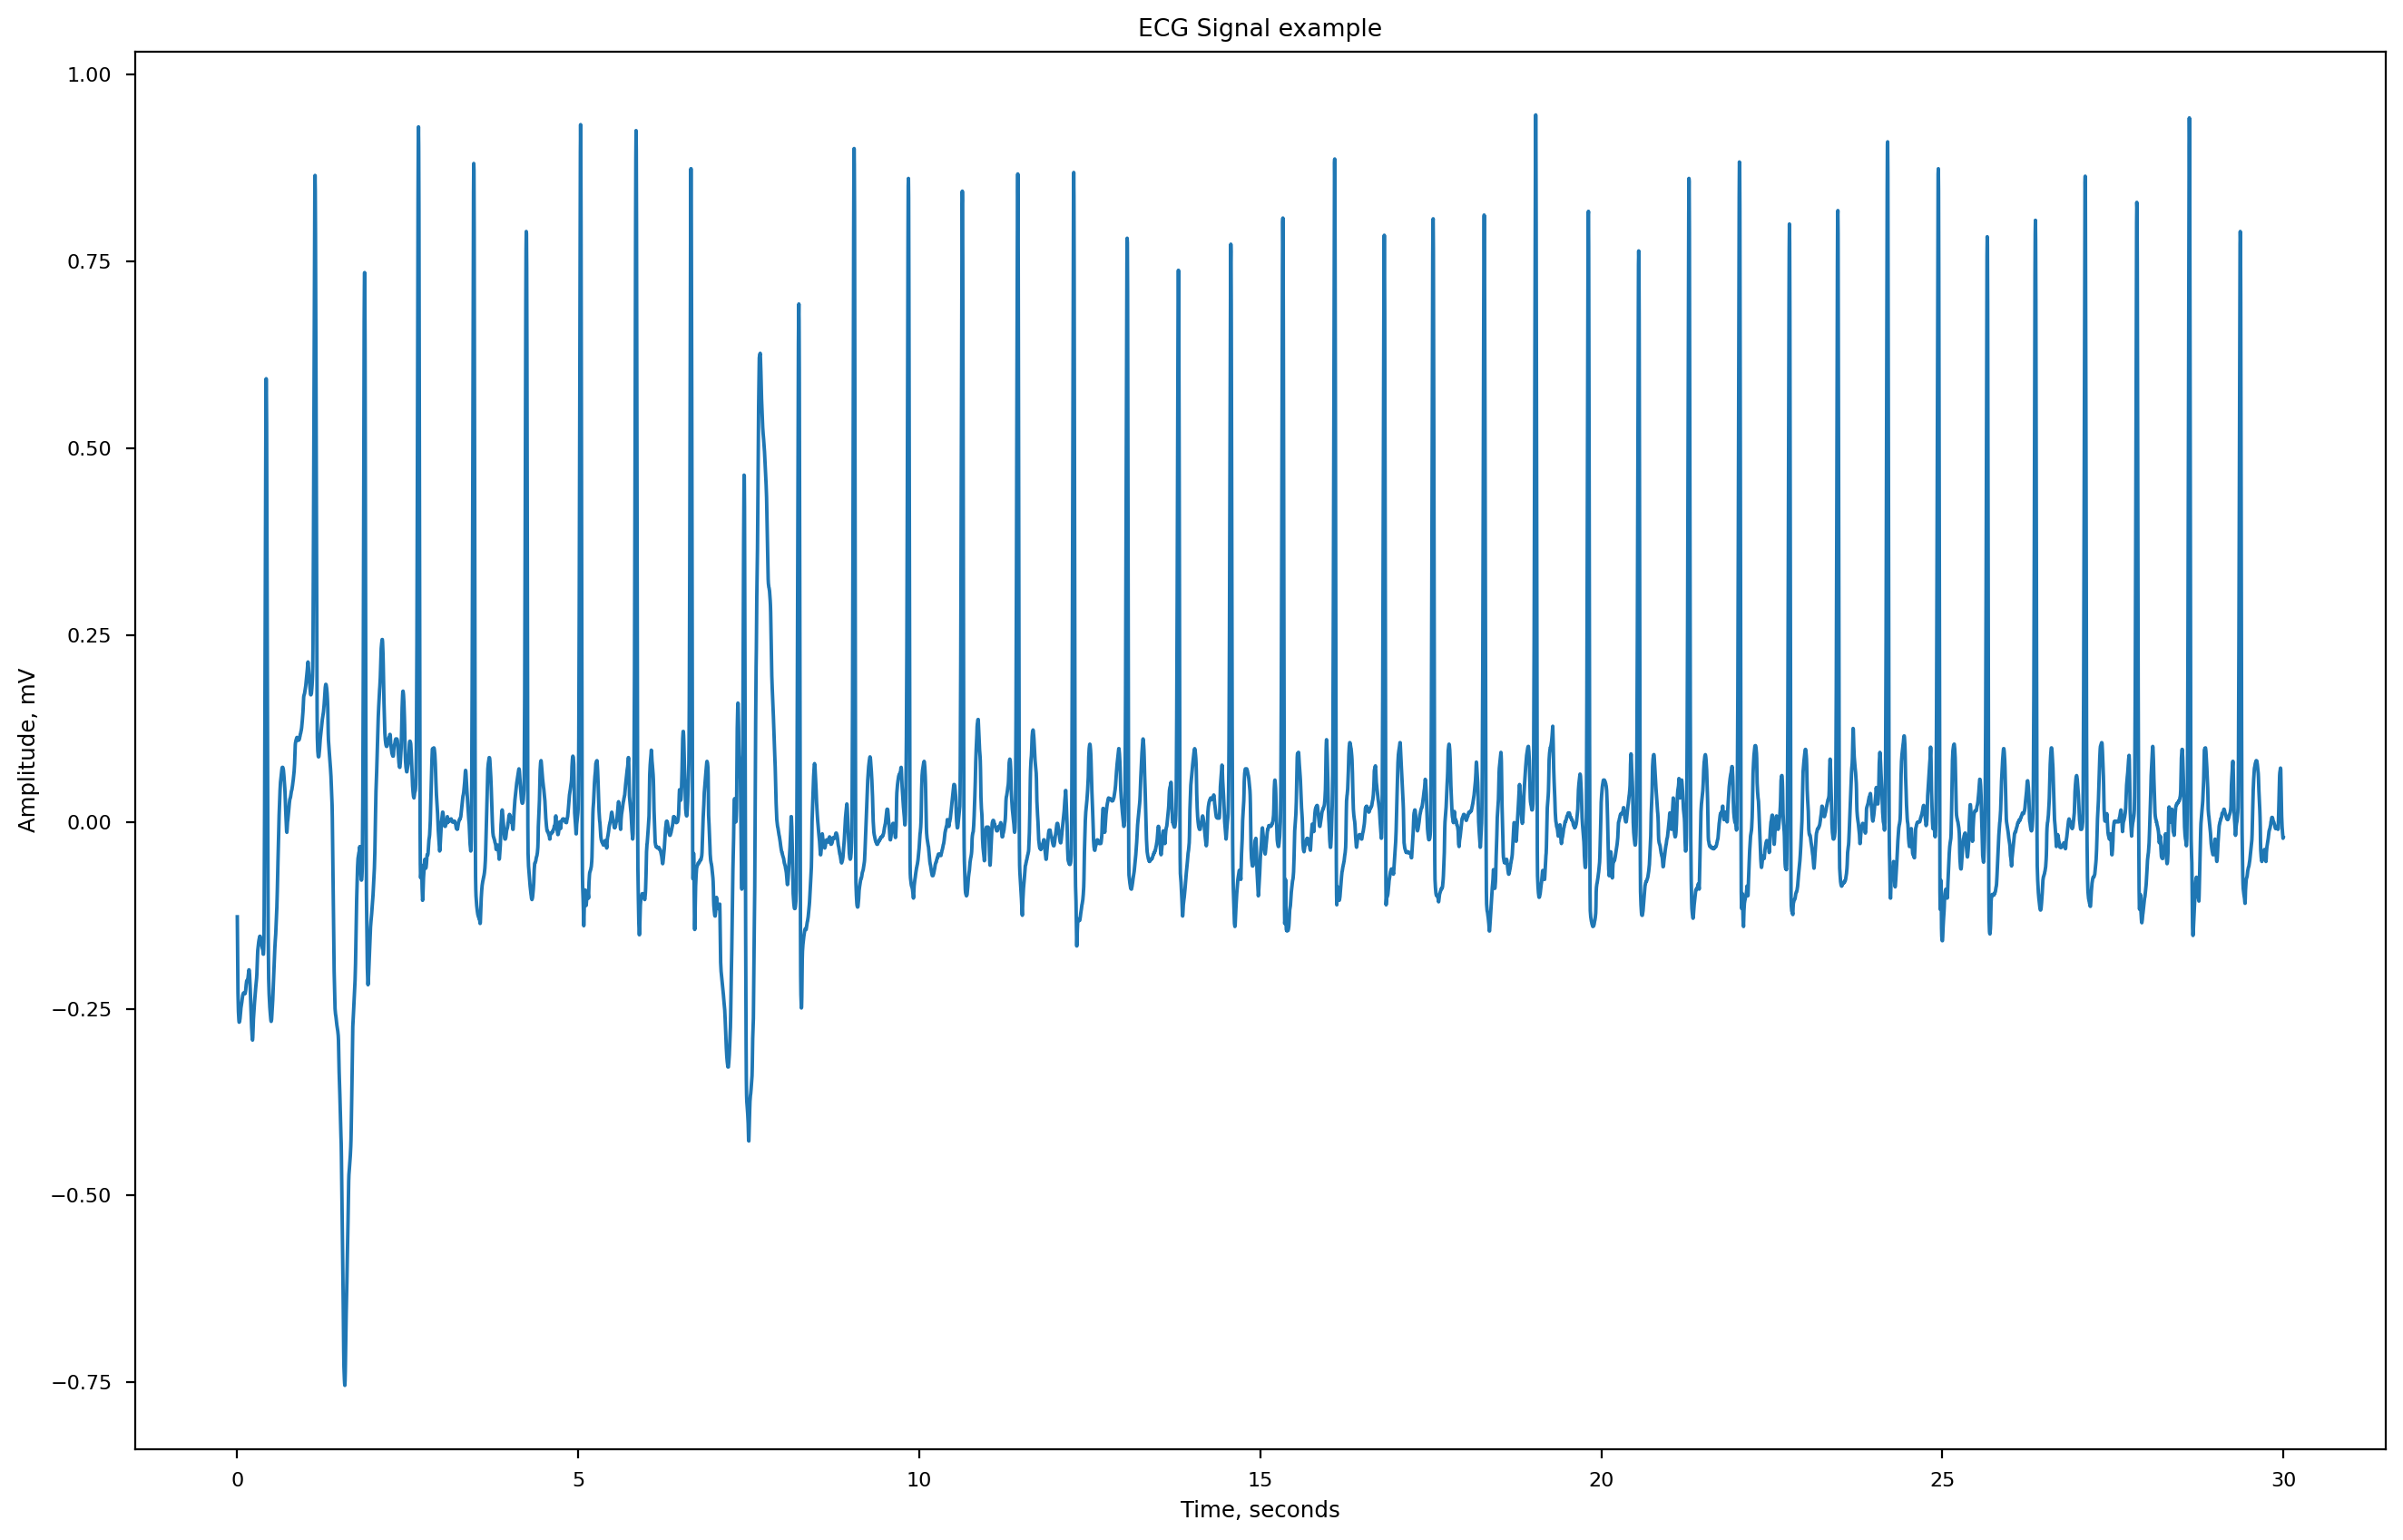

In [7]:
plt.figure(figsize=(16, 10))
plt.plot(np.arange(rec.shape[0]) / SAMPLING_RATE, rec / 1000)
plt.xlabel("Time, seconds")
plt.ylabel("Amplitude, mV")
plt.title("ECG Signal example")

In [8]:
# here are the labels
df = pd.read_csv(os.path.join(basepath, "REFERENCE.csv"), names=["name", "label"])
df.head()

name label
0  A00001     N
1  A00002     N
2  A00003     N
3  A00004     A
4  A00005     A

In [9]:
df.shape

(8528, 2)

In [10]:
basepath = "training2017"
df = pd.read_csv(os.path.join(basepath, "REFERENCE.csv"), names=["name", "label"])
times, recs = [], []
for idx, name in enumerate(df["name"]):
    rec = os.path.join(basepath, f"{name}.mat")
    header = os.path.join(basepath, name)
    rec = sci.loadmat(rec)["val"][0]
    
    time, rec = np.arange(rec.shape[0]) / SAMPLING_RATE, rec / 1000
    times.append(time)
    recs.append(rec)

df["time"] = times
df["values"] = recs
df["label"] = [0 if elm == "N" else 1 for elm in df["label"]]

In [11]:
df.head()

name  label                                               time  \
0  A00001      0  [0.0, 0.0033333333333333335, 0.006666666666666...   
1  A00002      0  [0.0, 0.0033333333333333335, 0.006666666666666...   
2  A00003      0  [0.0, 0.0033333333333333335, 0.006666666666666...   
3  A00004      1  [0.0, 0.0033333333333333335, 0.006666666666666...   
4  A00005      1  [0.0, 0.0033333333333333335, 0.006666666666666...   

                                              values  
0  [-0.127, -0.162, -0.197, -0.229, -0.245, -0.25...  
1  [0.128, 0.157, 0.189, 0.226, 0.25, 0.257, 0.26...  
2  [0.056, 0.073, 0.085, 0.093, 0.1, 0.107, 0.113...  
3  [0.519, 0.619, 0.723, 0.827, 0.914, 0.956, 0.9...  
4  [-0.188, -0.239, -0.274, -0.316, -0.356, -0.37...

## EDA

In [12]:
ecg_signal = df["values"][0]
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=SAMPLING_RATE)

In [13]:
rpeaks

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 127,  342,  560,  797, 1040, 1271, 1510, 1754, 1995, 2229, 2470,
        2713, 2952, 3189, 3433, 3679, 3914, 4139, 4370, 4599, 4827, 5045,
        5260, 5484, 5711, 5943, 6164, 6385, 6607, 6827, 7040, 7259, 7482,
        7697, 7909, 8128, 8355, 8586, 8810]),
 'sampling_rate': 300}

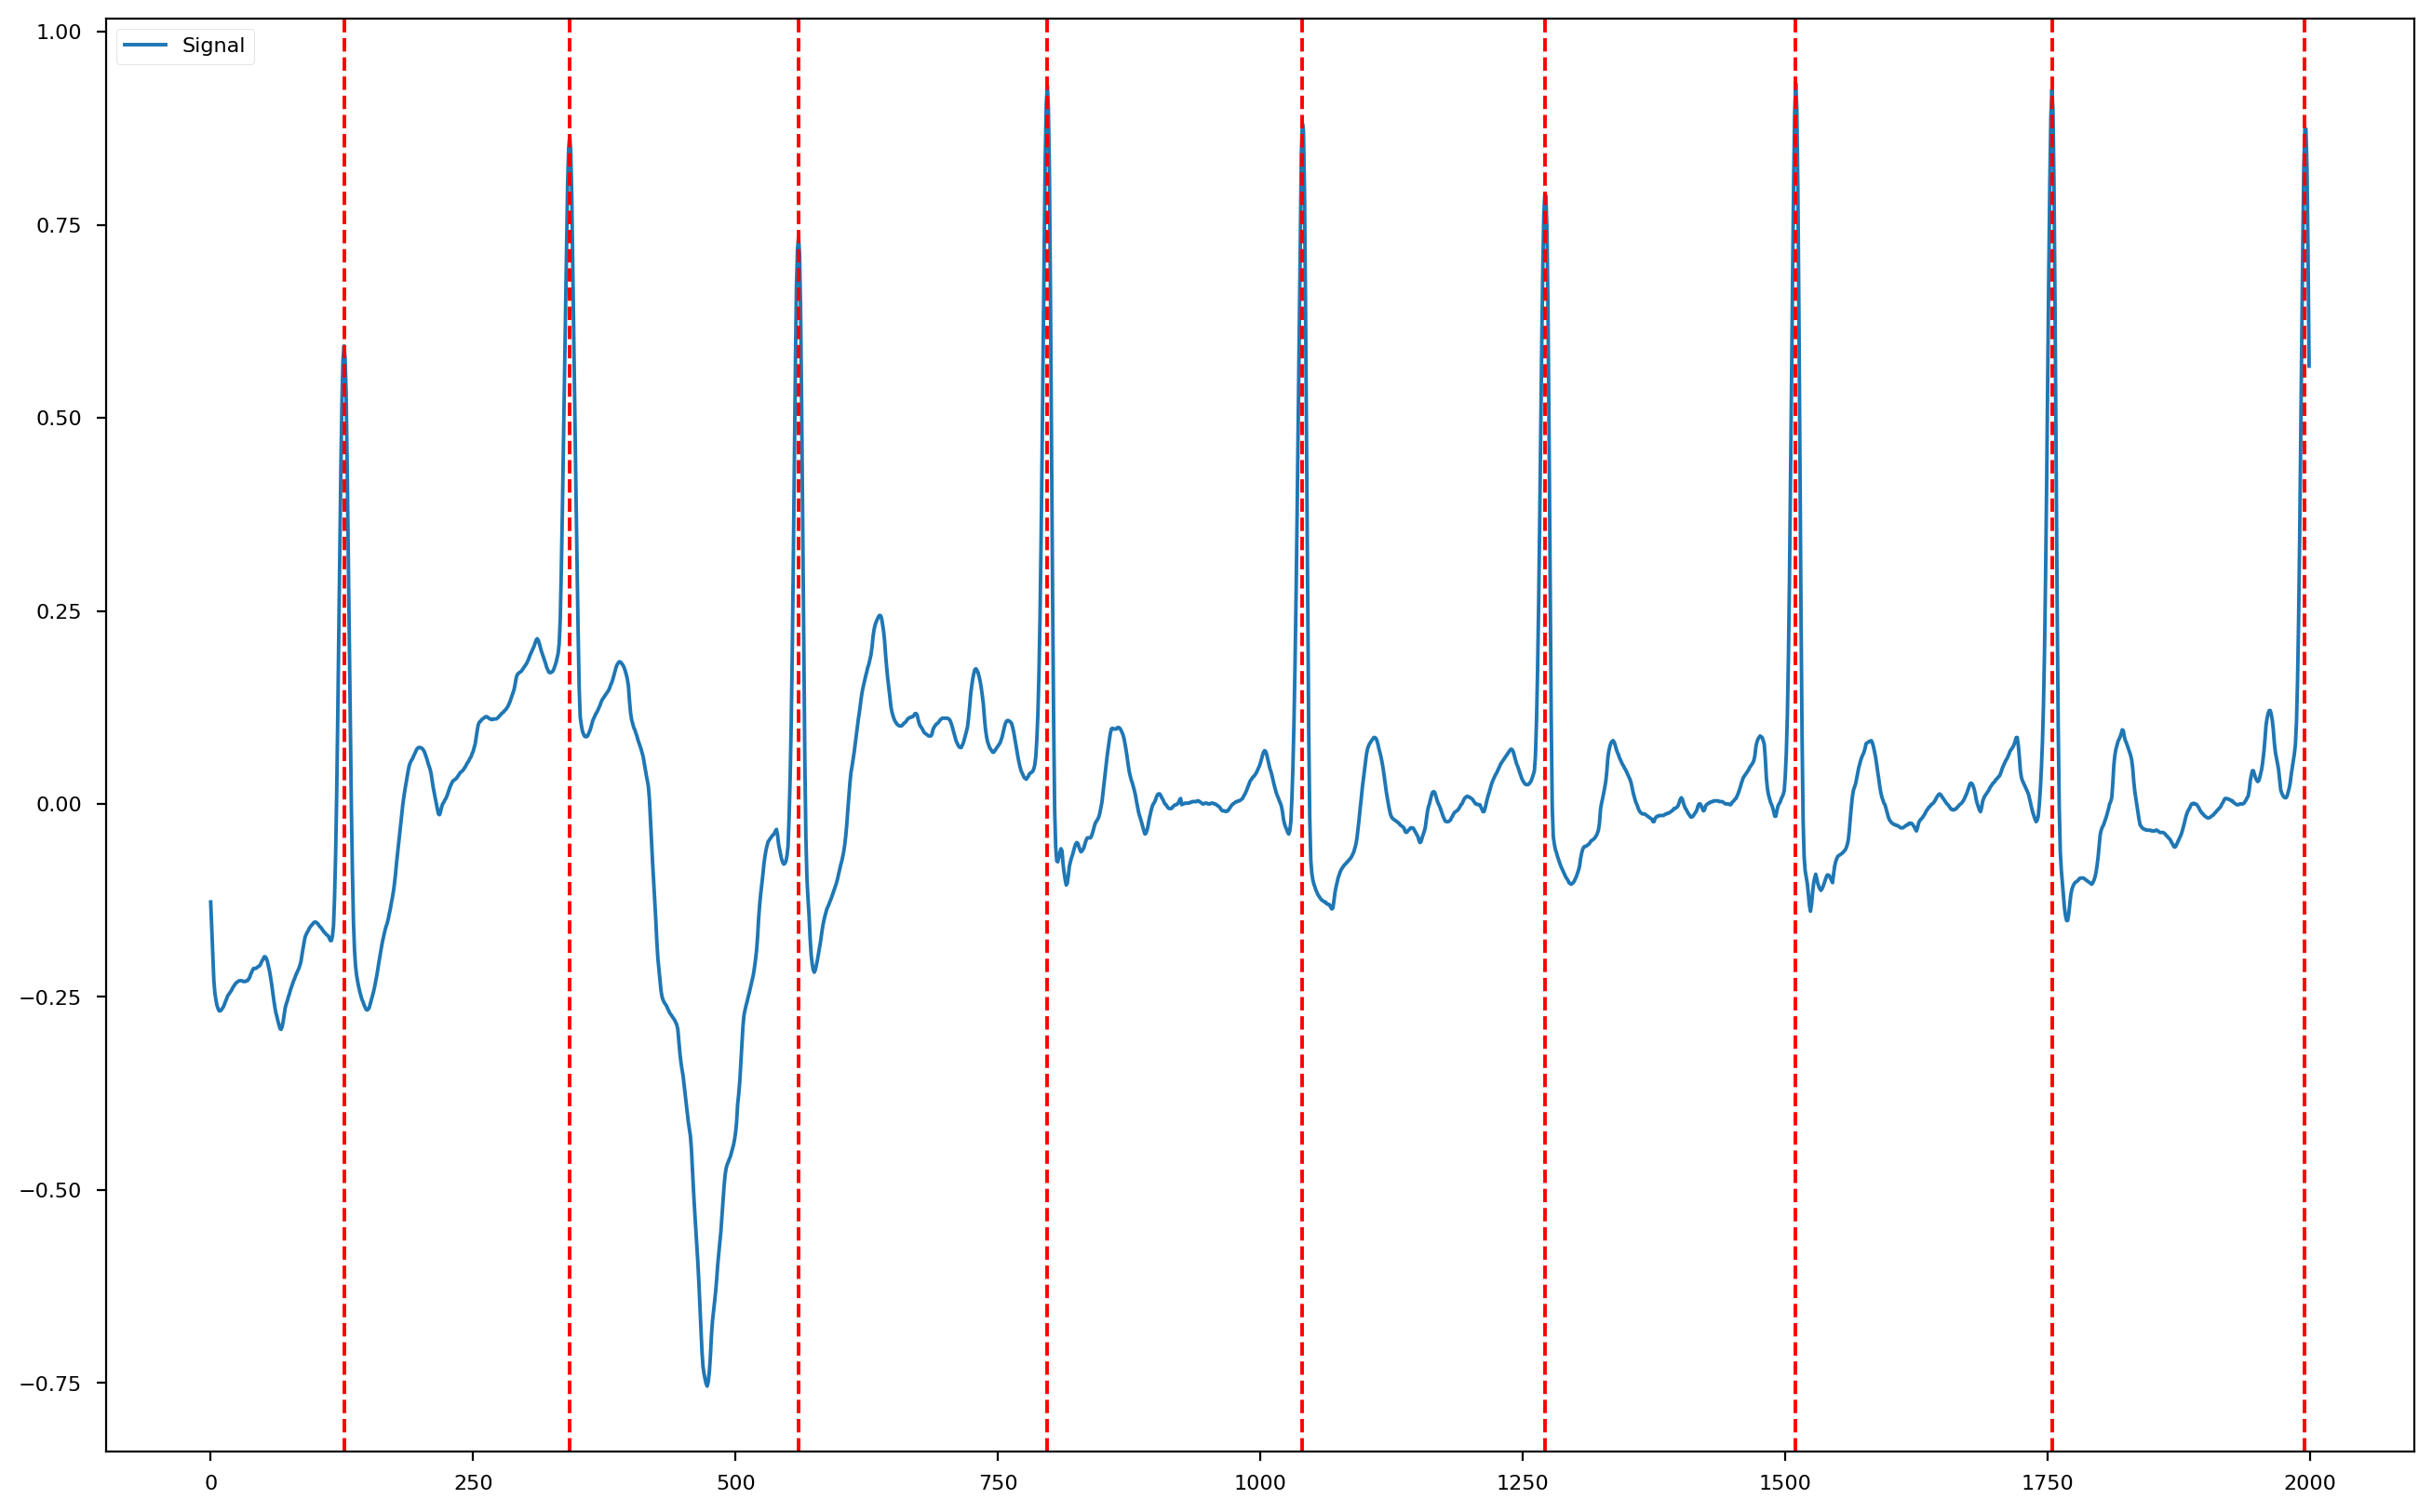

In [14]:
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:9], ecg_signal[:2000])

In [15]:
_, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

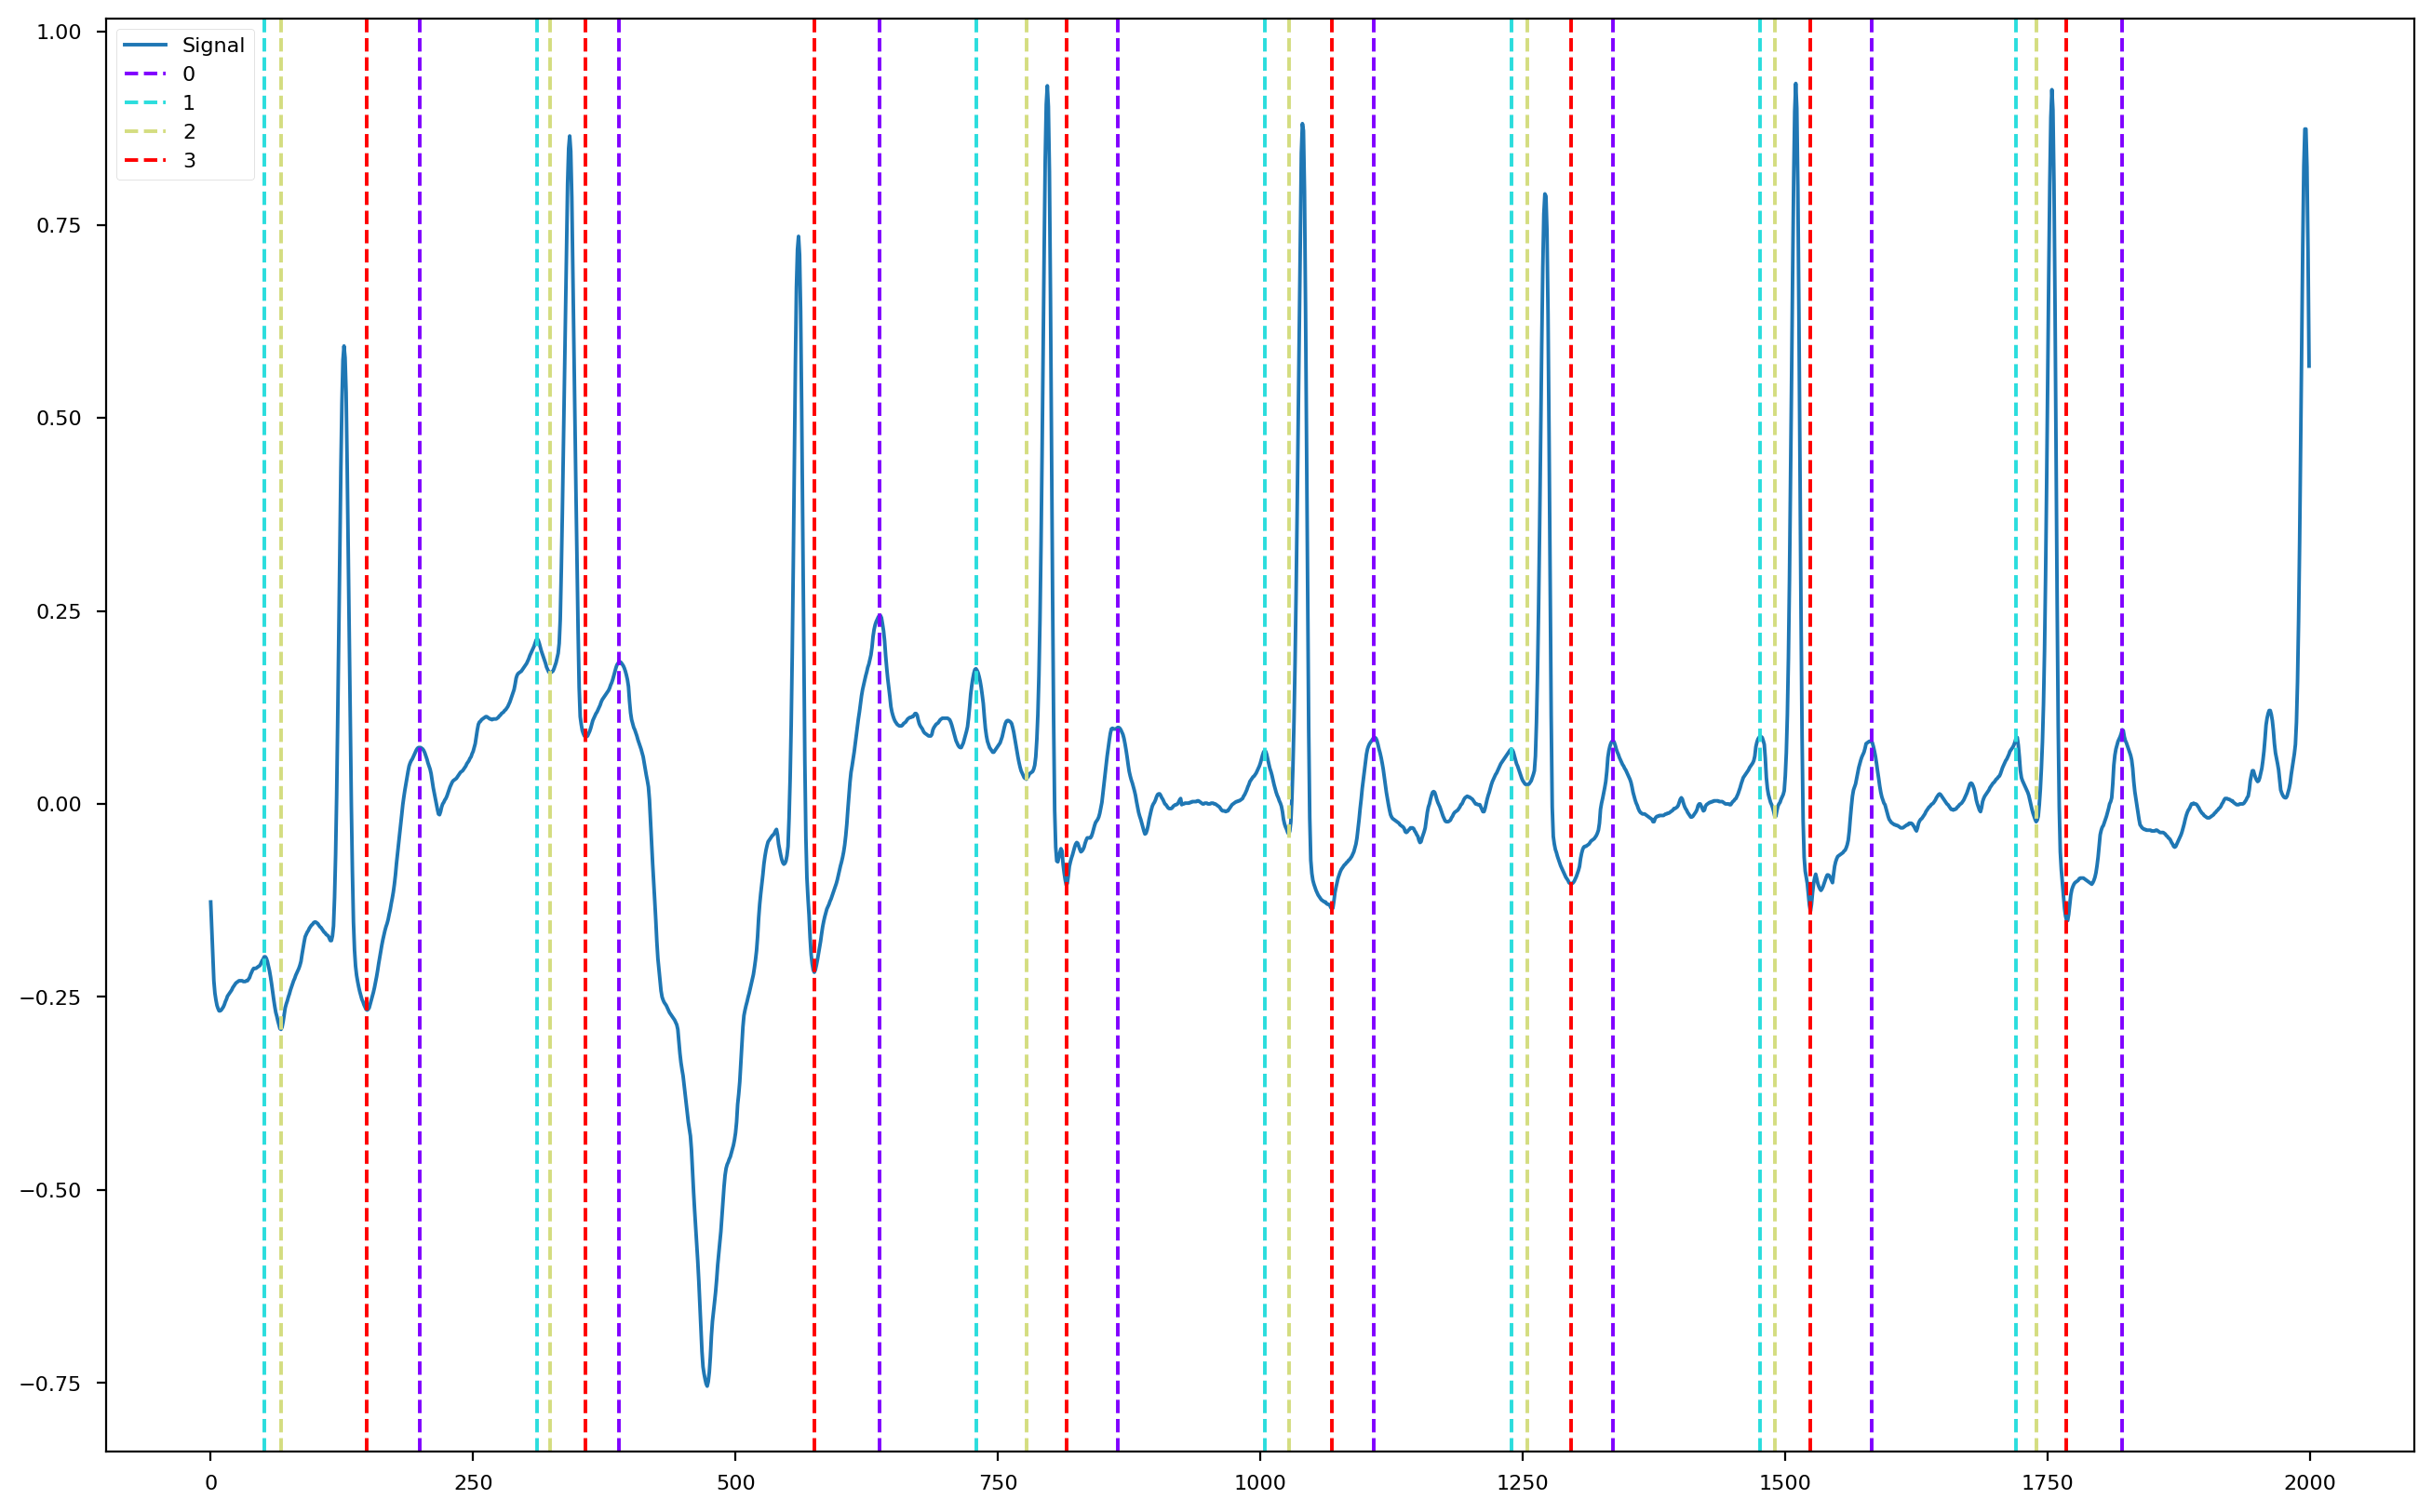

In [16]:
plot = nk.events_plot(
     [
        waves_peak['ECG_T_Peaks'][:8], 
        waves_peak['ECG_P_Peaks'][:8],
        waves_peak['ECG_Q_Peaks'][:8],
        waves_peak['ECG_S_Peaks'][:8]
     ],
    ecg_signal[:2000]
)

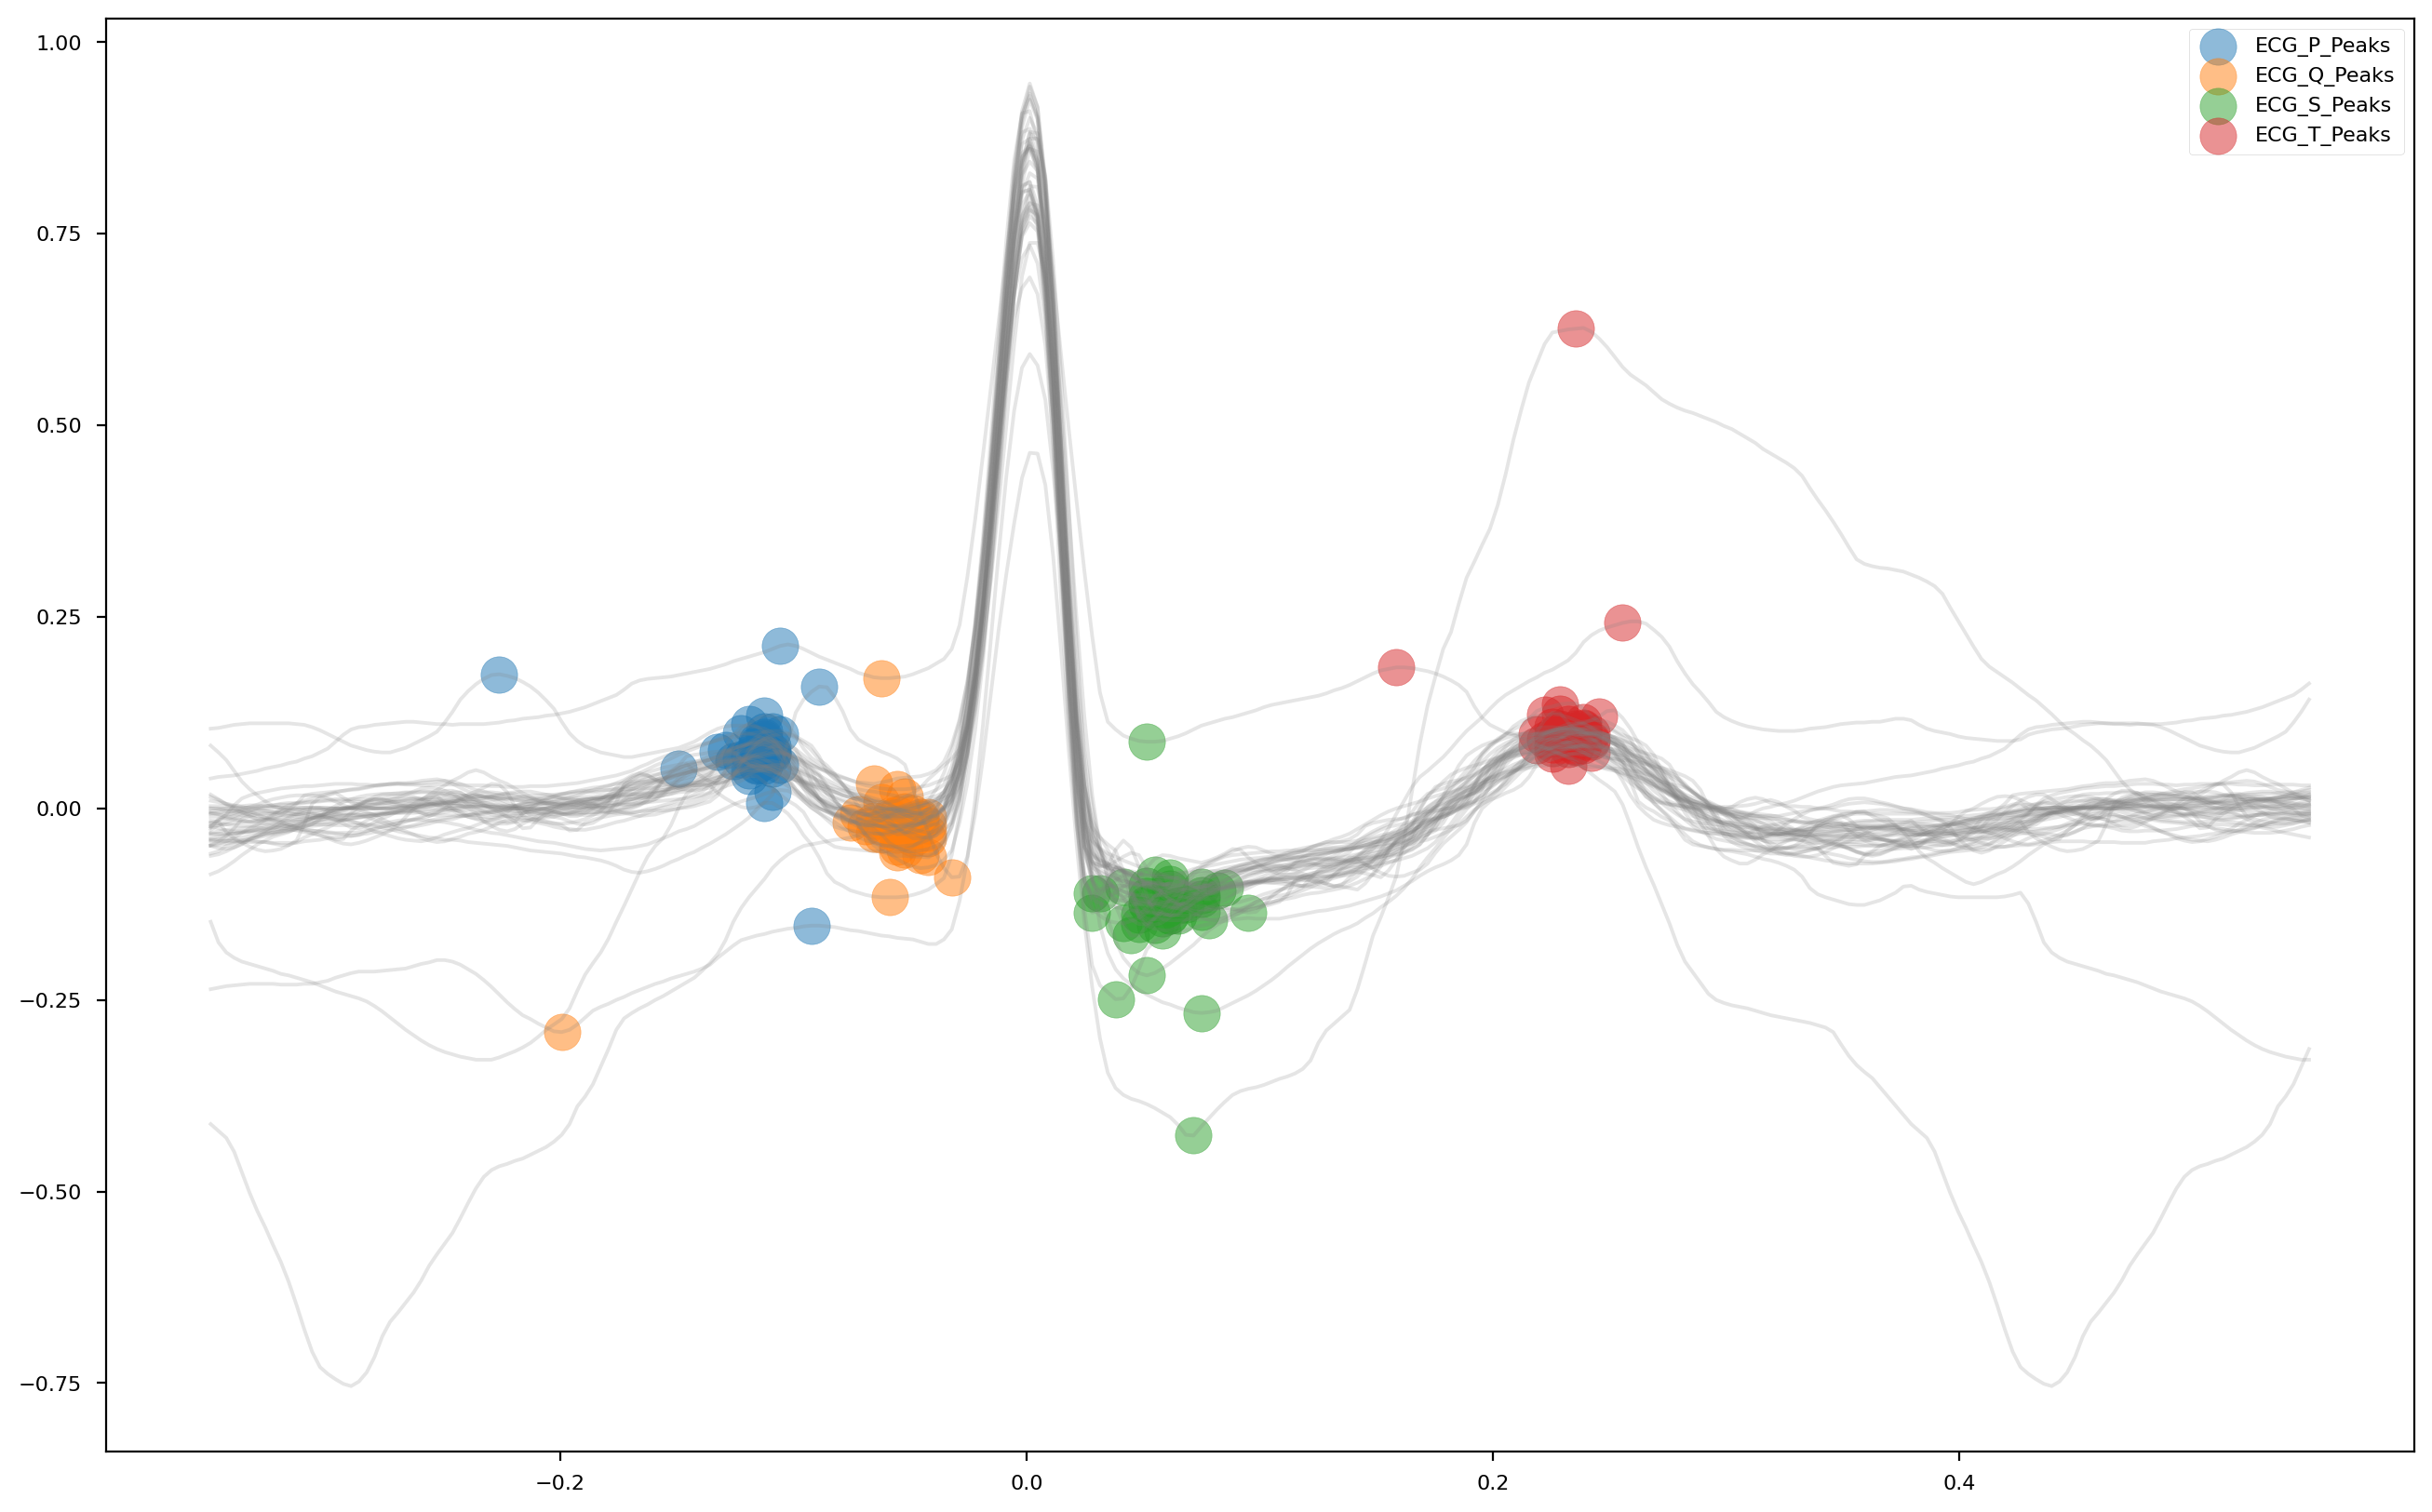

In [17]:
_, waves_peak = nk.ecg_delineate(ecg_signal, 
    rpeaks, 
    sampling_rate=SAMPLING_RATE, 
    method="dwt", 
    show=True, 
    show_type='peaks'
)

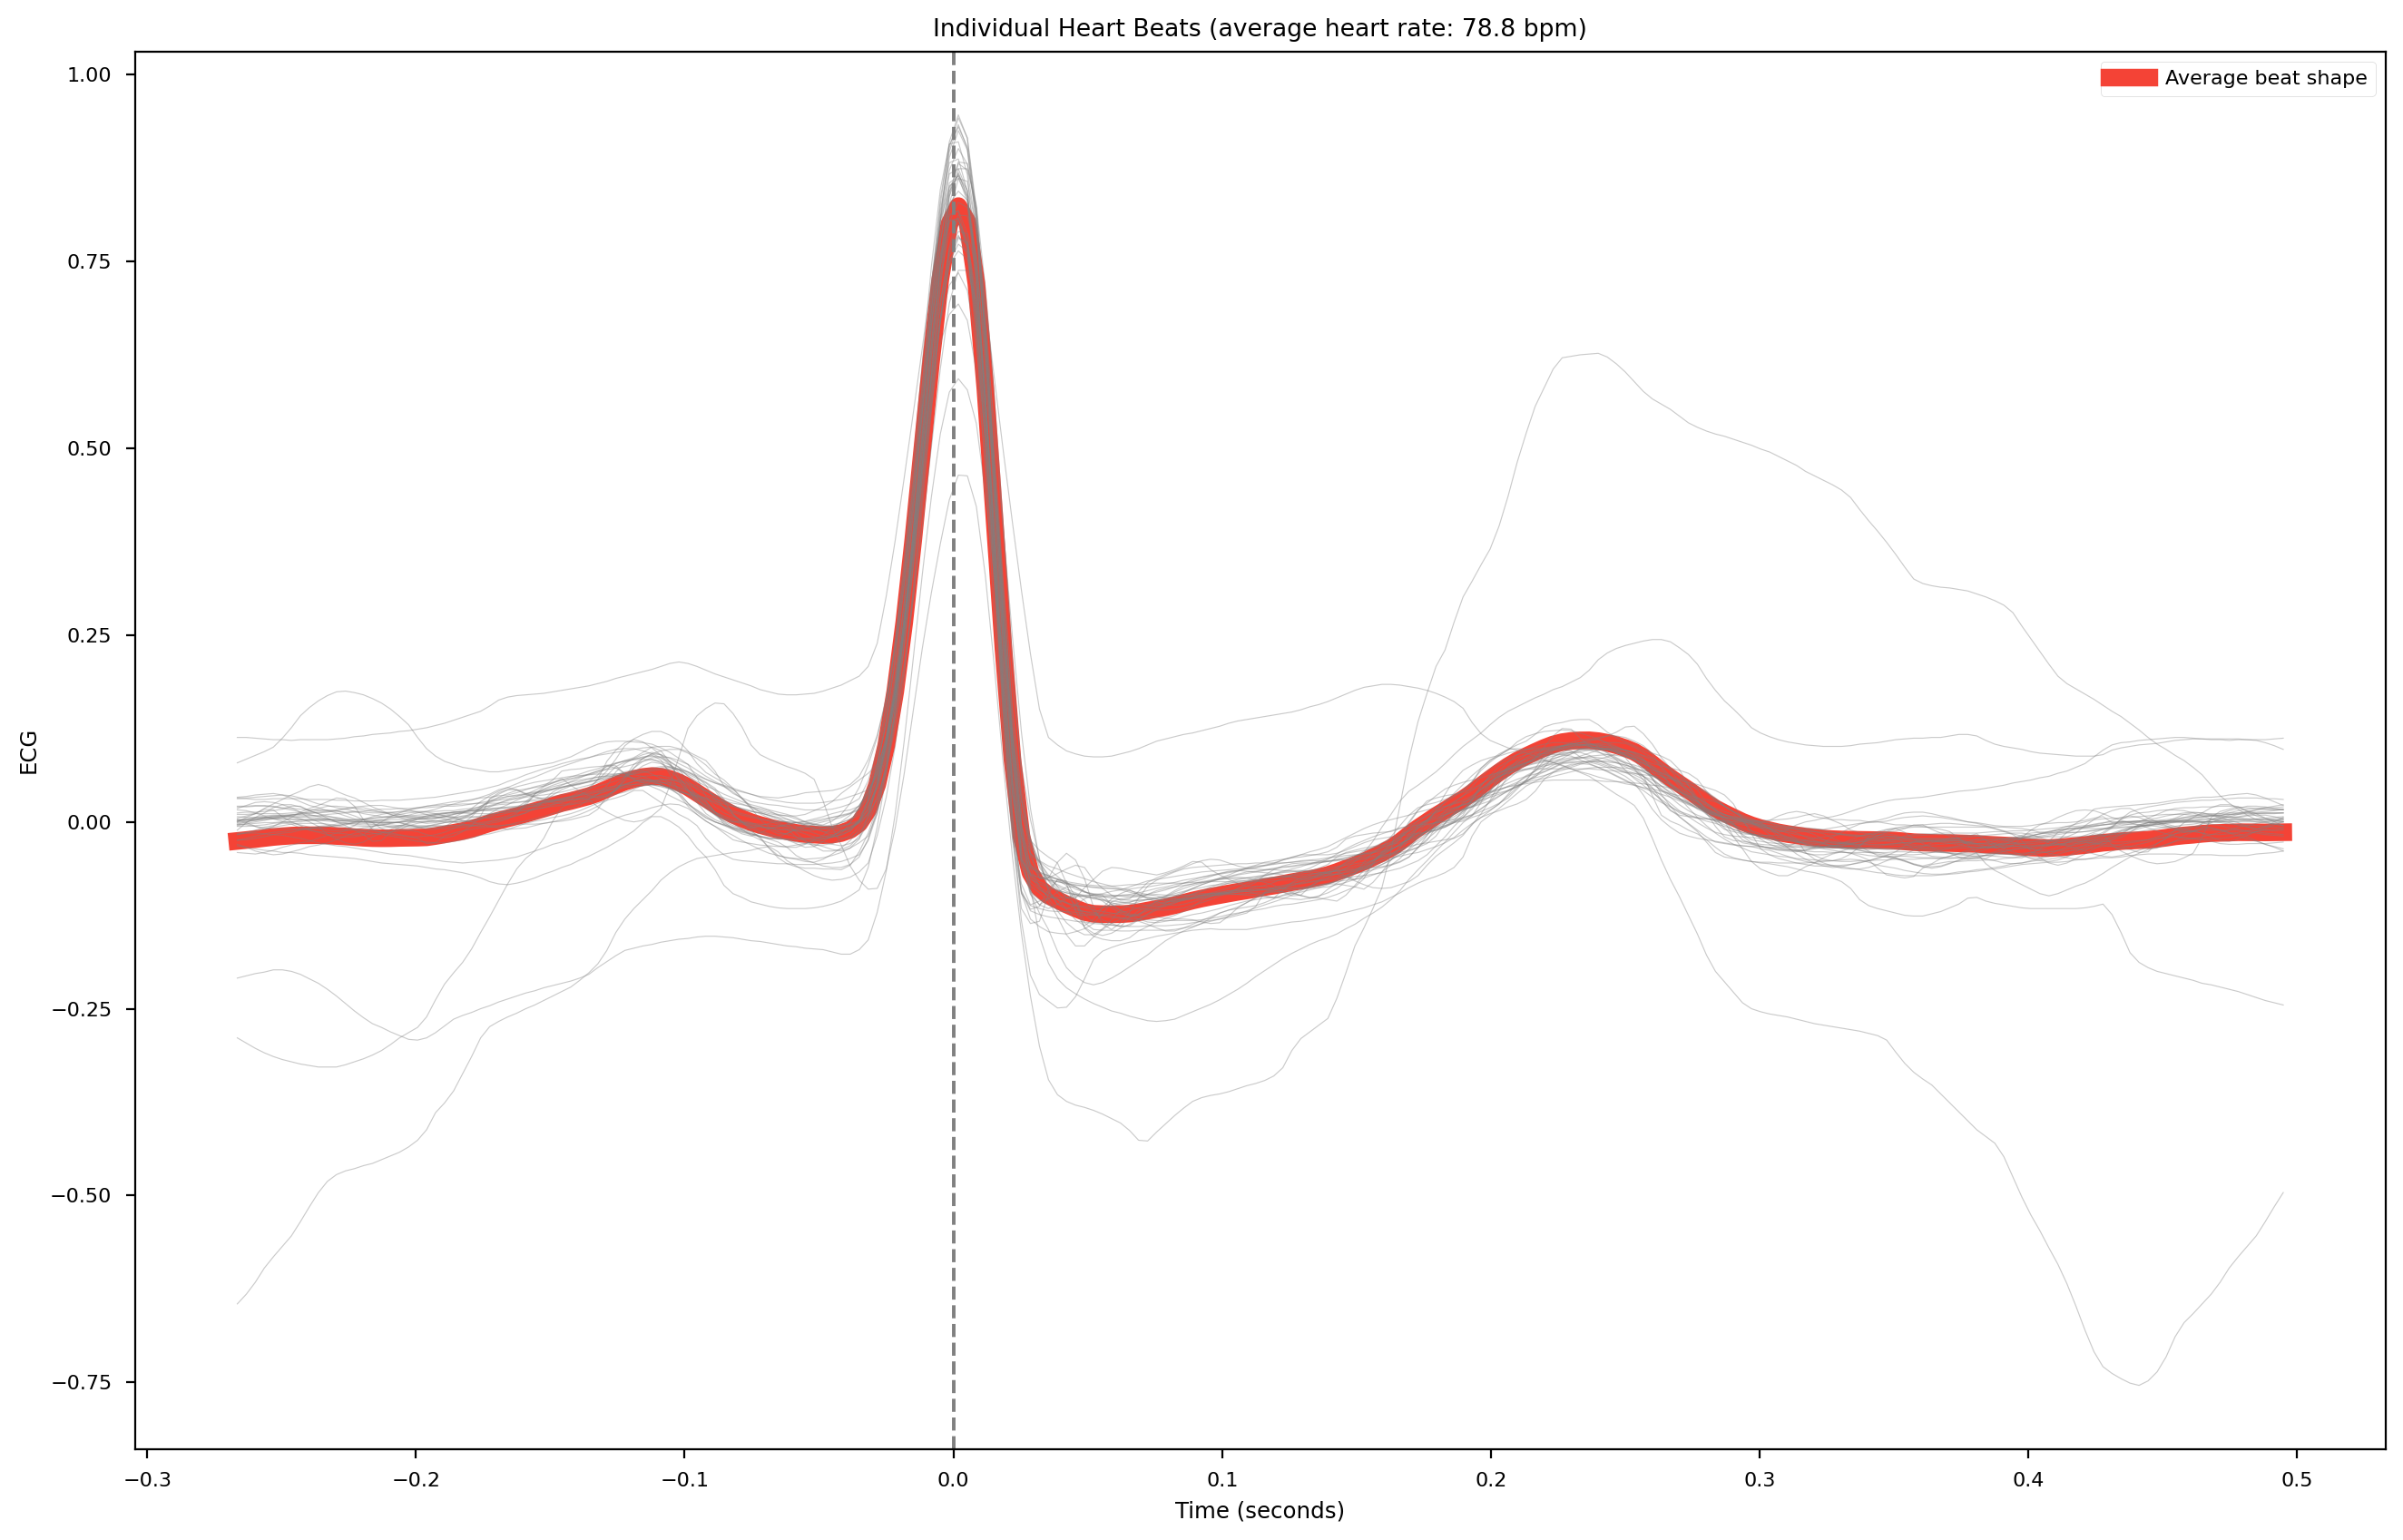

In [18]:
epochs = nk.ecg_segment(ecg_signal, rpeaks=None, sampling_rate=SAMPLING_RATE, show=True)

## Classical method

In [19]:
_, peaks = nk.ecg_peaks(ecg_signal, sampling_rate=SAMPLING_RATE)
rr = np.ediff1d(peaks["ECG_R_Peaks"])
rr_hist = np.histogram(rr)
rr_hist

(array([5, 2, 6, 4, 3, 5, 2, 4, 2, 5]),
 array([212. , 215.4, 218.8, 222.2, 225.6, 229. , 232.4, 235.8, 239.2,
        242.6, 246. ]))

<Axes: ylabel='Count'>

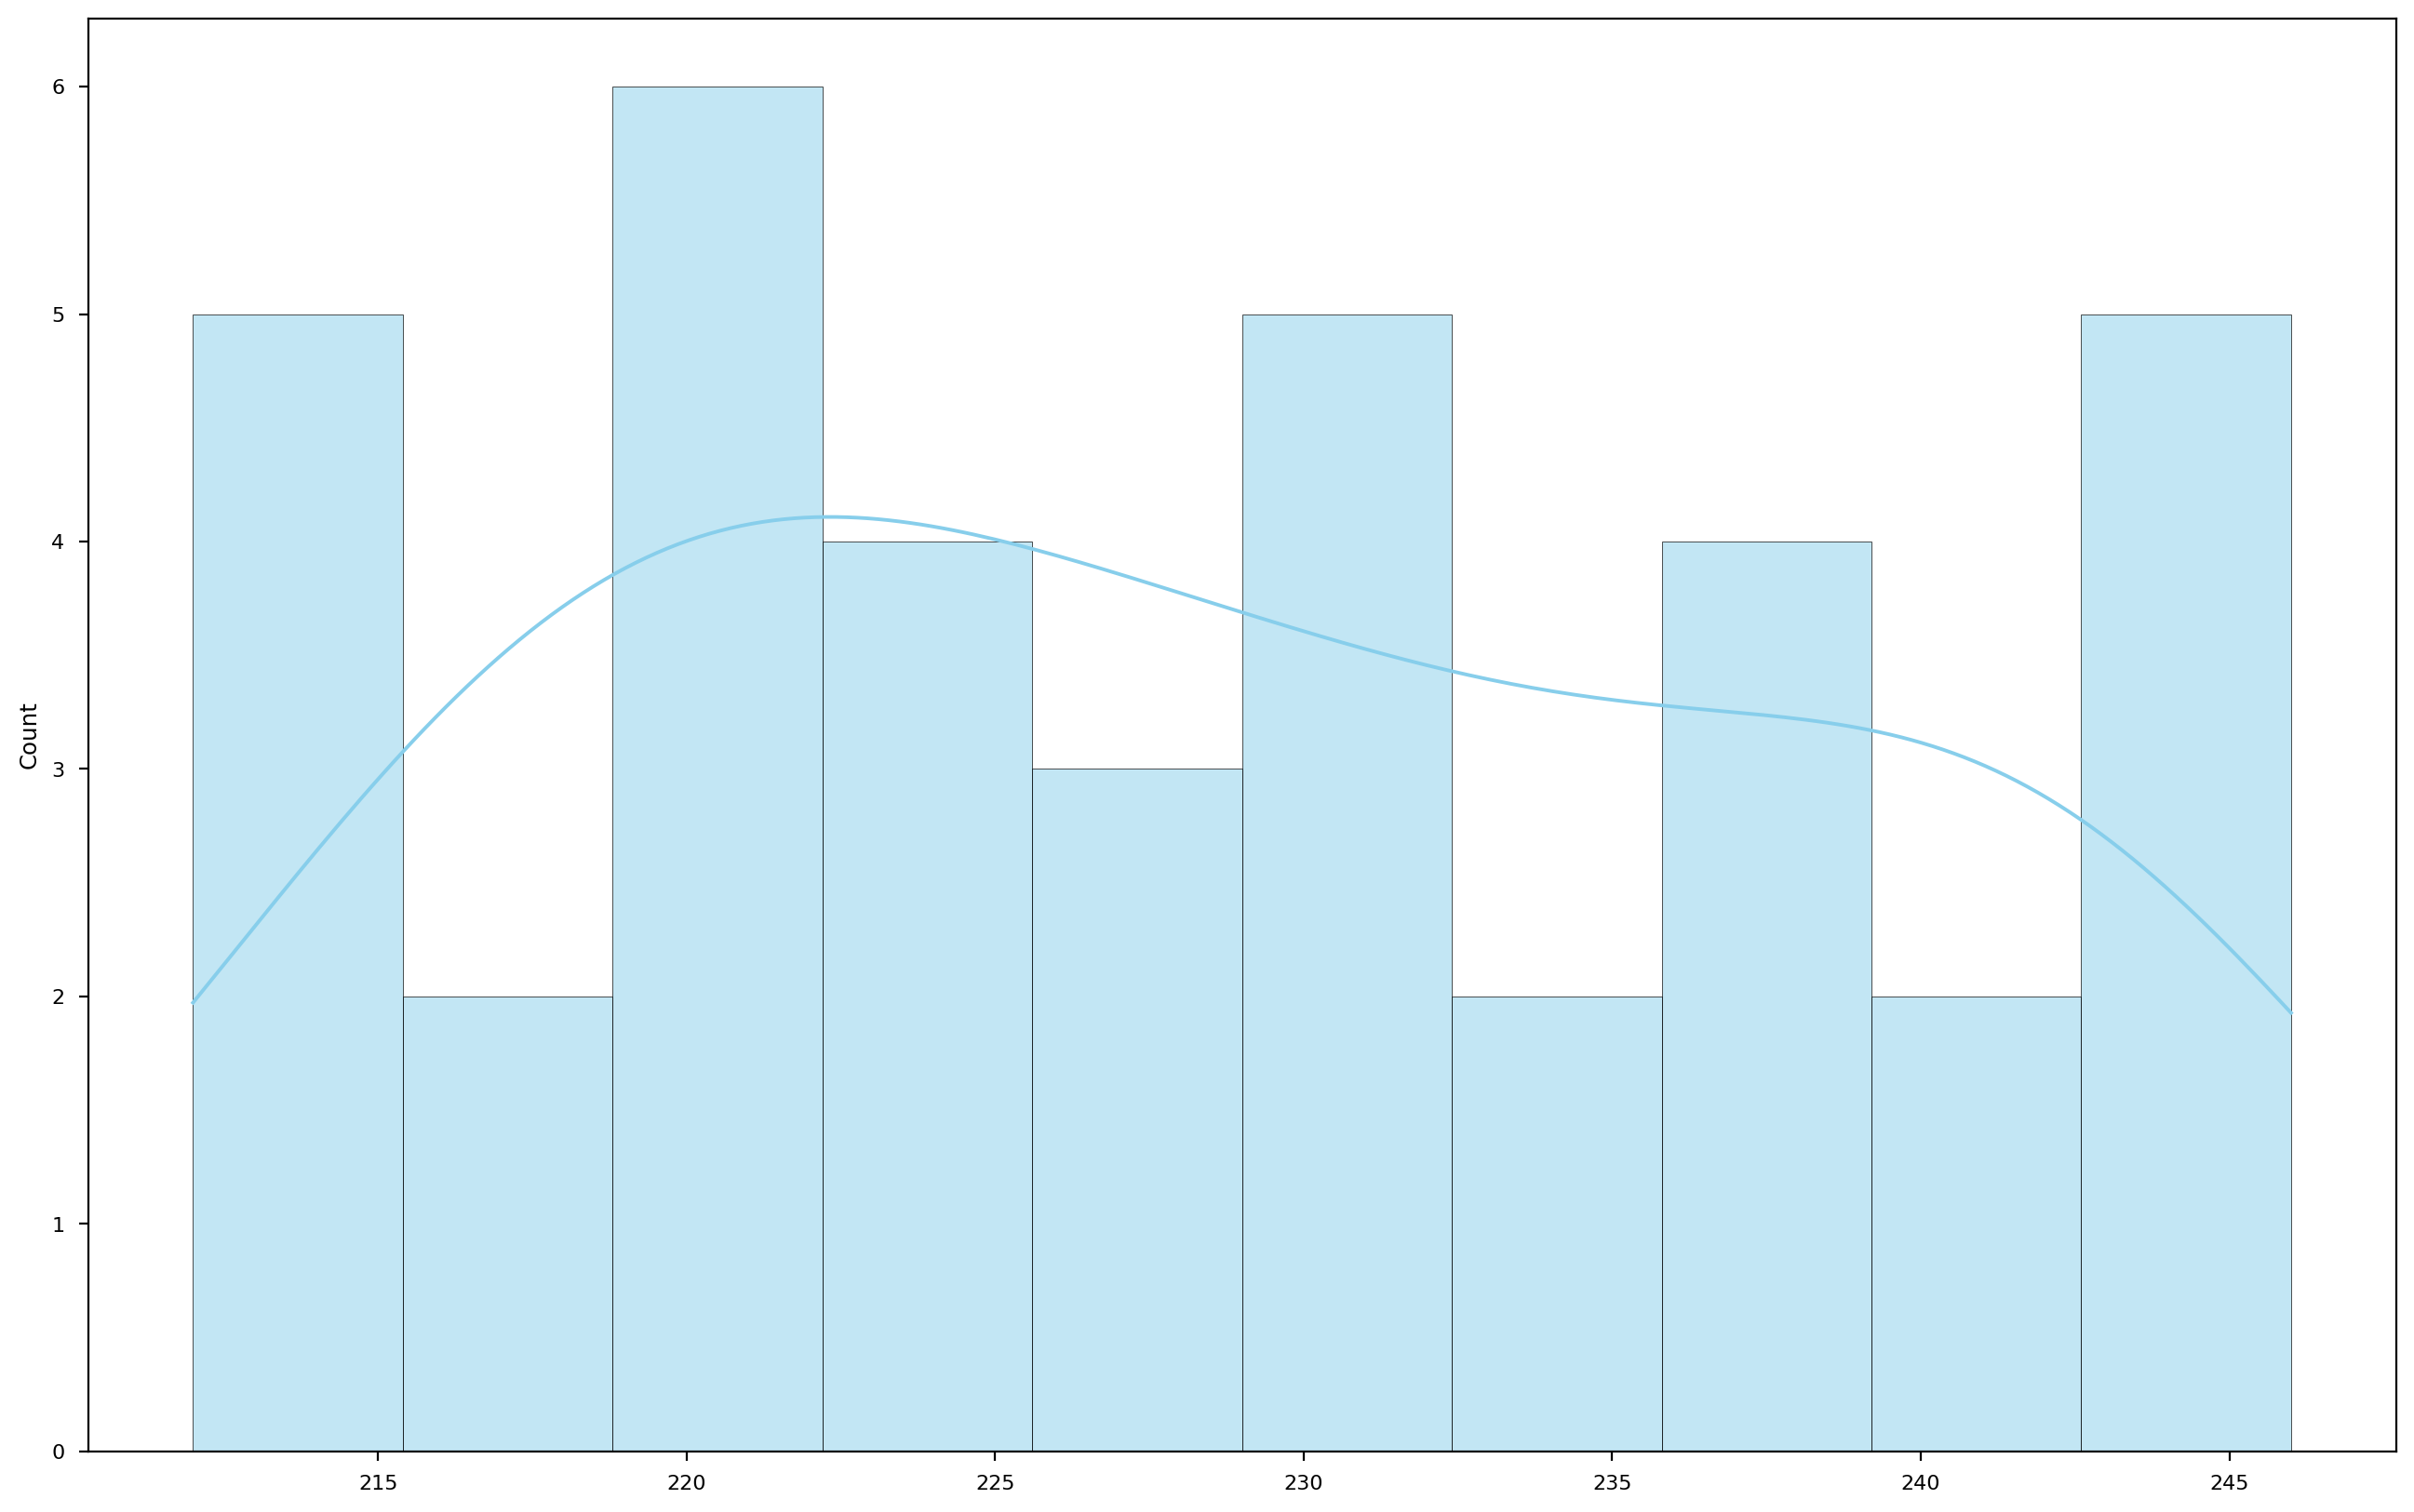

In [20]:
sns.histplot(rr, bins=10, kde=True, color='skyblue', edgecolor='black')

In [21]:
X, y = df["values"], df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
bad_rrs, normal_rrs = [], []

for i in tqdm(range(X_train.shape[0])):
    sig, label = X_train.values[i], y_train.values[i]

    try:
        _, peaks = nk.ecg_peaks(sig, sampling_rate=SAMPLING_RATE)
    except Exception as ex:
        continue
    rr = np.ediff1d(peaks["ECG_R_Peaks"])
    if label:
        normal_rrs.extend(rr)
    else:
        bad_rrs.extend(rr)

bad_hist = np.histogram(bad_rrs)
normal_hist = np.histogram(normal_rrs)

100%|██████████| 6822/6822 [00:03<00:00, 1766.96it/s]


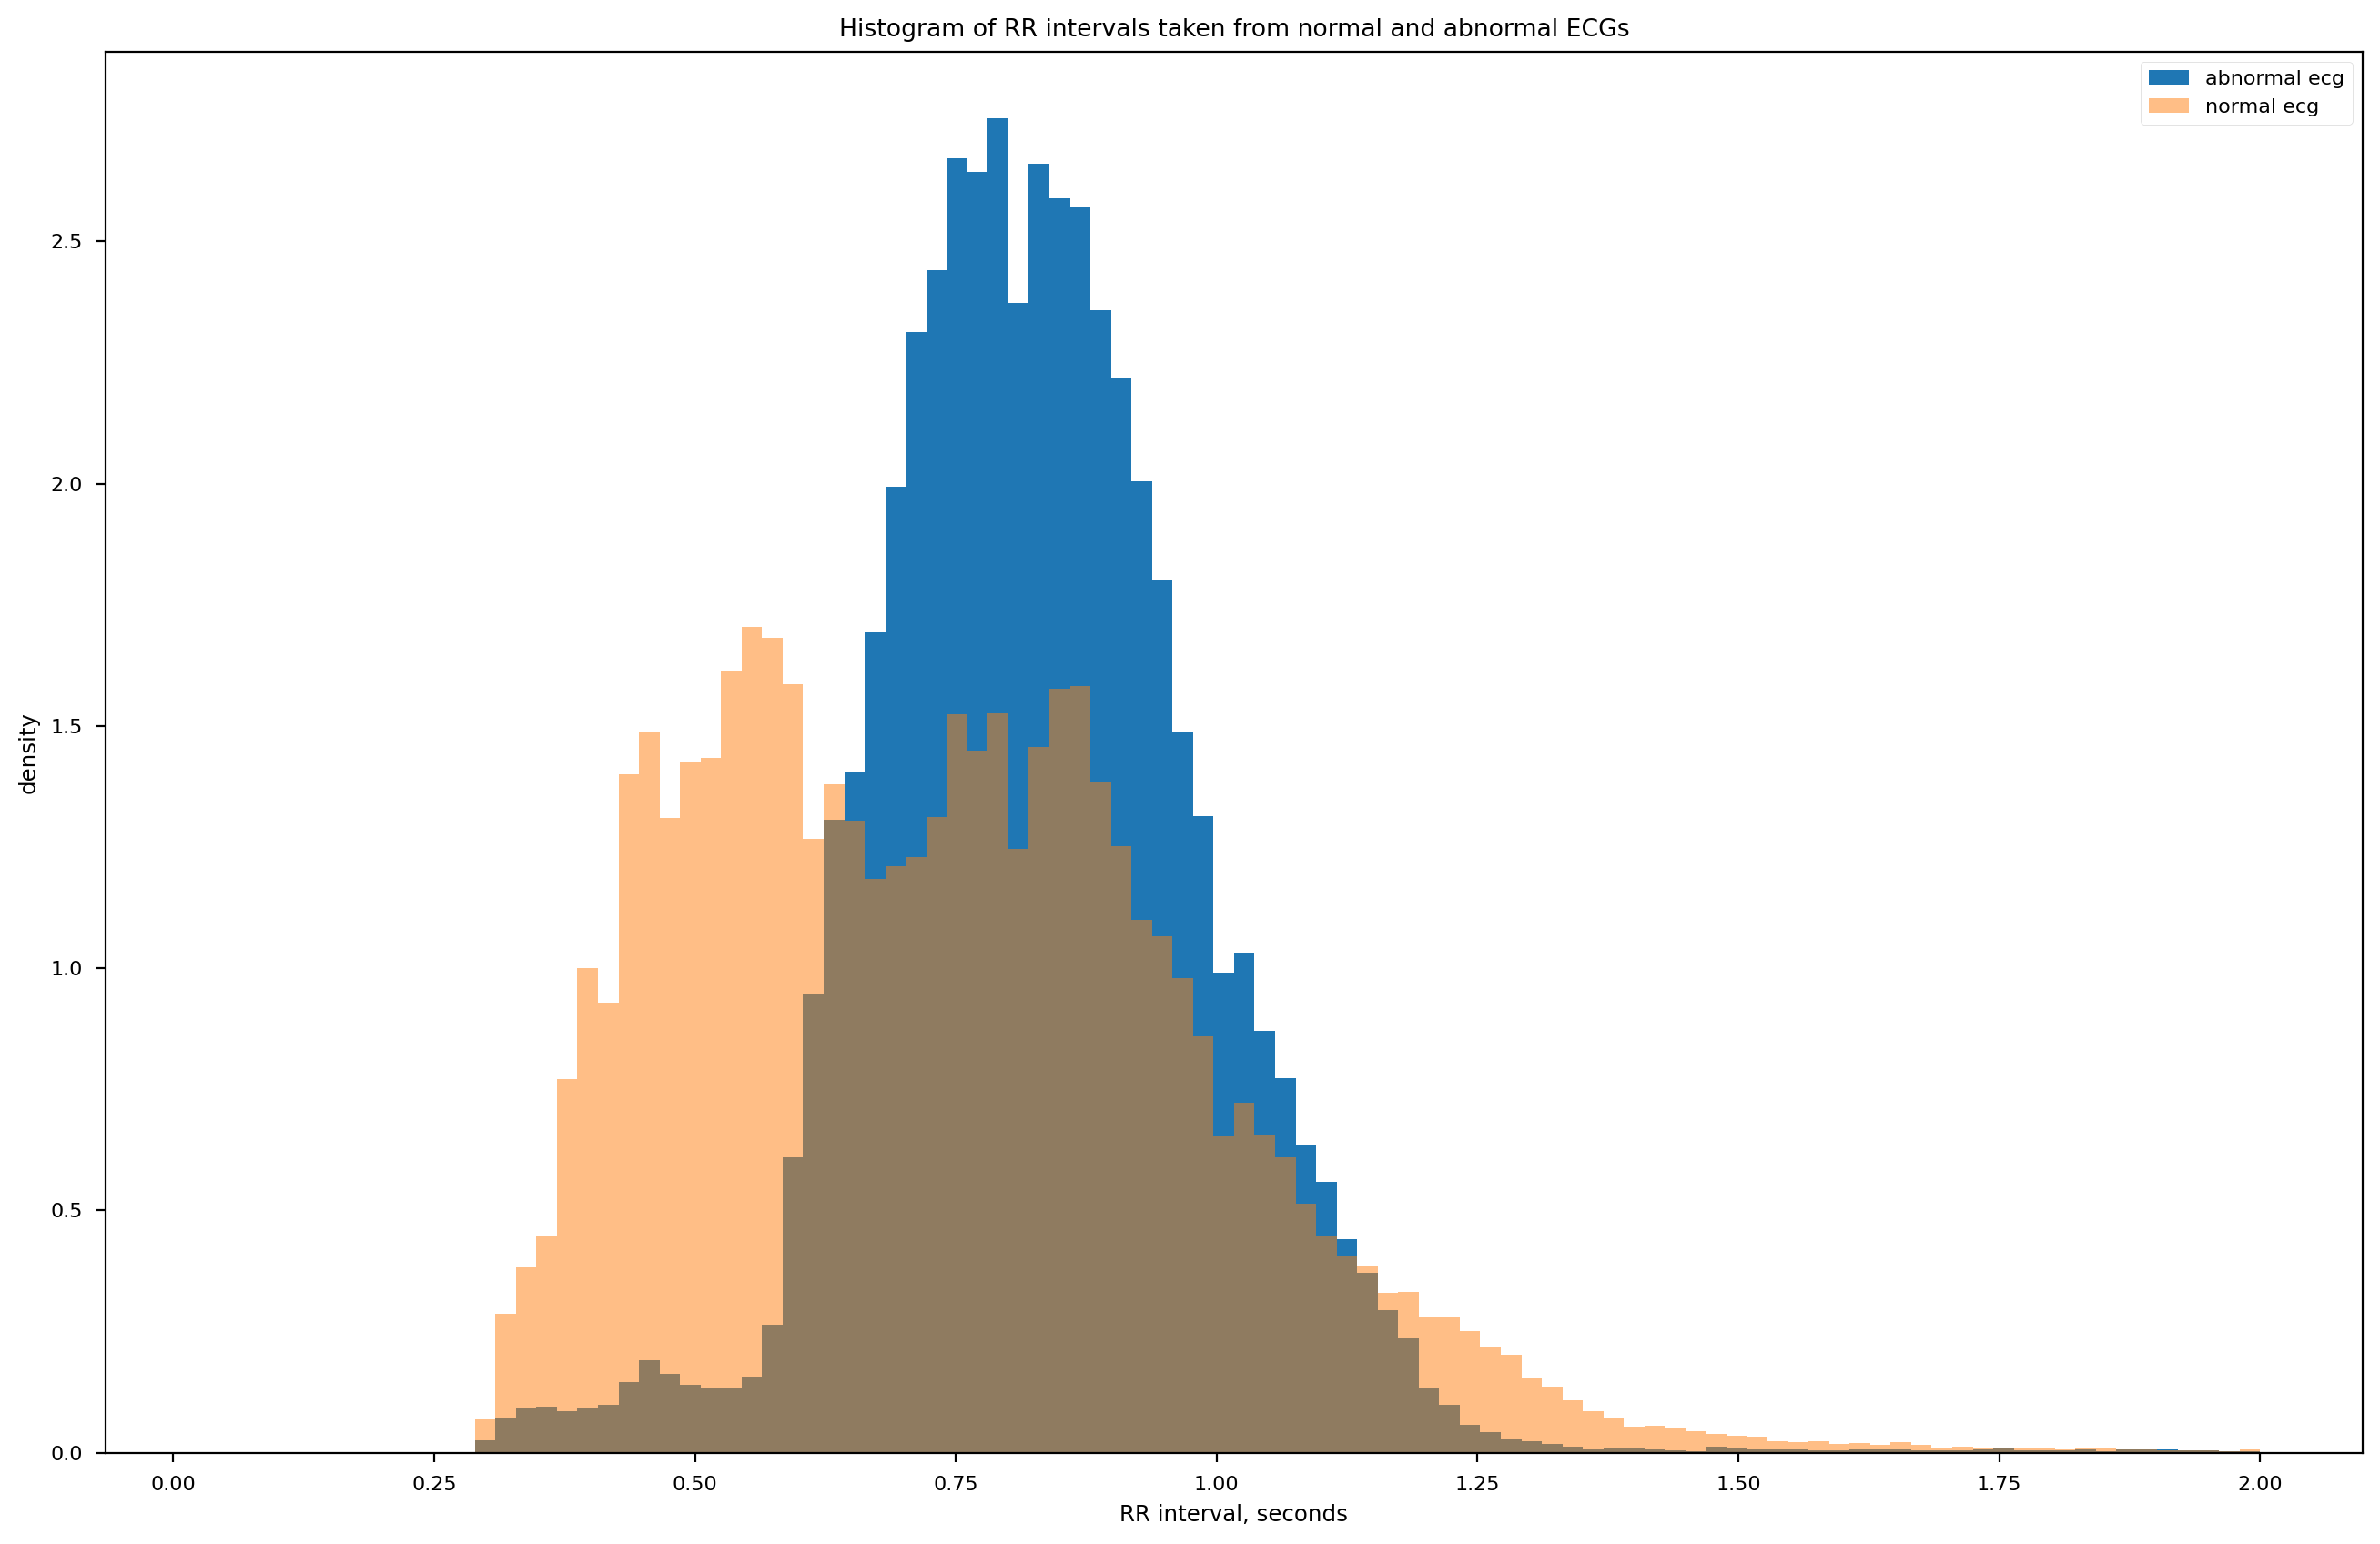

In [23]:
plt.hist(np.array(bad_rrs) / SAMPLING_RATE, bins=100, range=(10 / SAMPLING_RATE, 600 / SAMPLING_RATE), density=True, label="abnormal ecg")
plt.hist(np.array(normal_rrs) / SAMPLING_RATE, bins=100, range=(10 / SAMPLING_RATE, 600 / SAMPLING_RATE), density=True, alpha=0.5, label="normal ecg")
plt.xlabel("RR interval, seconds")
plt.ylabel("density")
plt.title("Histogram of RR intervals taken from normal and abnormal ECGs")
plt.legend()

In [24]:
labels, pred_labels = [], []
for i in tqdm(range(X_test.shape[0])):
    sig, label = X_test.values[i], y_test.values[i]
    _, peaks = nk.ecg_peaks(sig, sampling_rate=SAMPLING_RATE)
    rr = np.ediff1d(peaks["ECG_R_Peaks"])
    pred_label = 1 if scipy.stats.ks_2samp(rr, normal_rrs) < scipy.stats.ks_2samp(rr, bad_rrs) else 0

    pred_labels.append(pred_label)
    labels.append(label)

100%|██████████| 1706/1706 [00:57<00:00, 29.90it/s]


Accuracy: 0.6066822977725674
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      1049
           1       0.49      0.62      0.55       657

    accuracy                           0.61      1706
   macro avg       0.60      0.61      0.60      1706
weighted avg       0.63      0.61      0.61      1706



<Axes: >

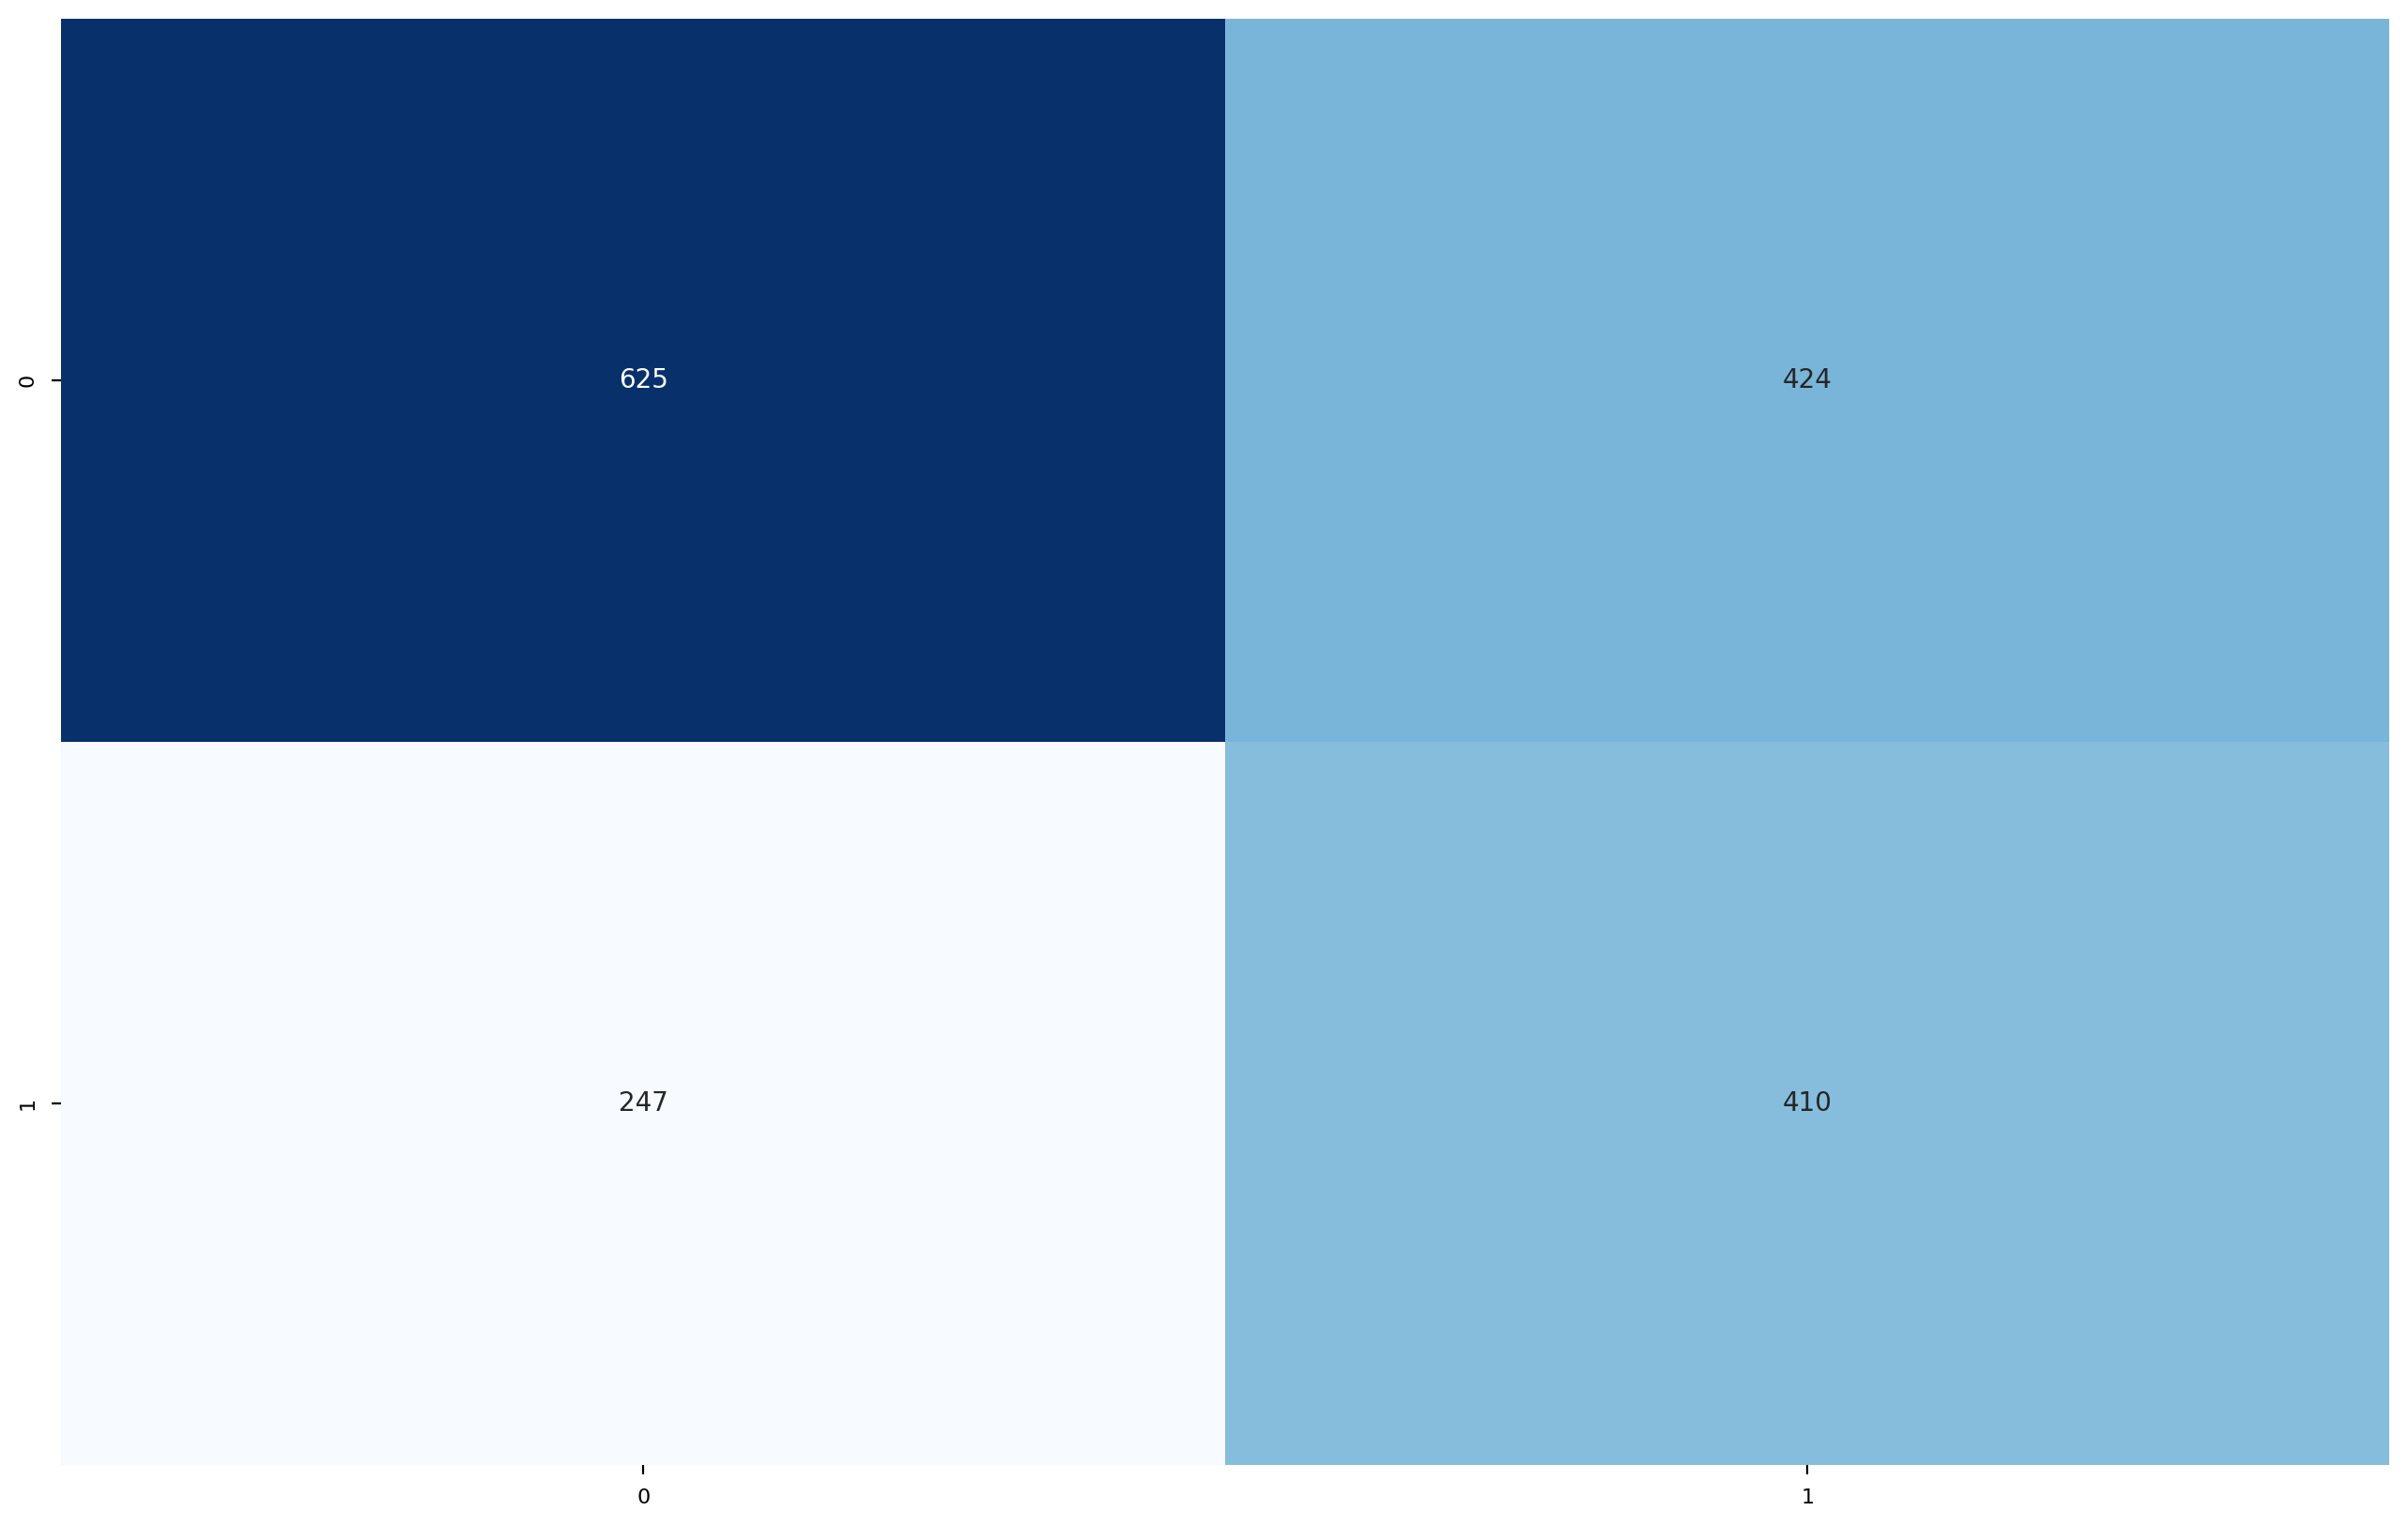

In [25]:
accuracy = accuracy_score(labels, pred_labels)
conf_matrix = confusion_matrix(labels, pred_labels)
class_report = classification_report(labels, pred_labels)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.arange(2), yticklabels=np.arange(2))

## Machine Learning Baseline

In [26]:
from typing import List

def pad_signals(X: List[np.array]) -> np.array:
    for i in tqdm(range(len(X))):
        seq = np.array(X[i])

        if seq.shape[0] < 9000:
            X[i] = np.pad(seq, (0, 9000 - len(seq)))
        else:
            X[i] = X[i][:9000]

    return X

In [27]:
X = df['values'].to_list()
y = df['label']

In [28]:
X = pad_signals(X)

100%|██████████| 8528/8528 [00:00<00:00, 189865.89it/s]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(multi_class='ovr', max_iter=1000)

In [30]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [31]:
y_pred = model.predict(X_test)

Accuracy: 0.515240328253224
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      1049
           1       0.36      0.33      0.35       657

    accuracy                           0.52      1706
   macro avg       0.48      0.48      0.48      1706
weighted avg       0.51      0.52      0.51      1706



<Axes: >

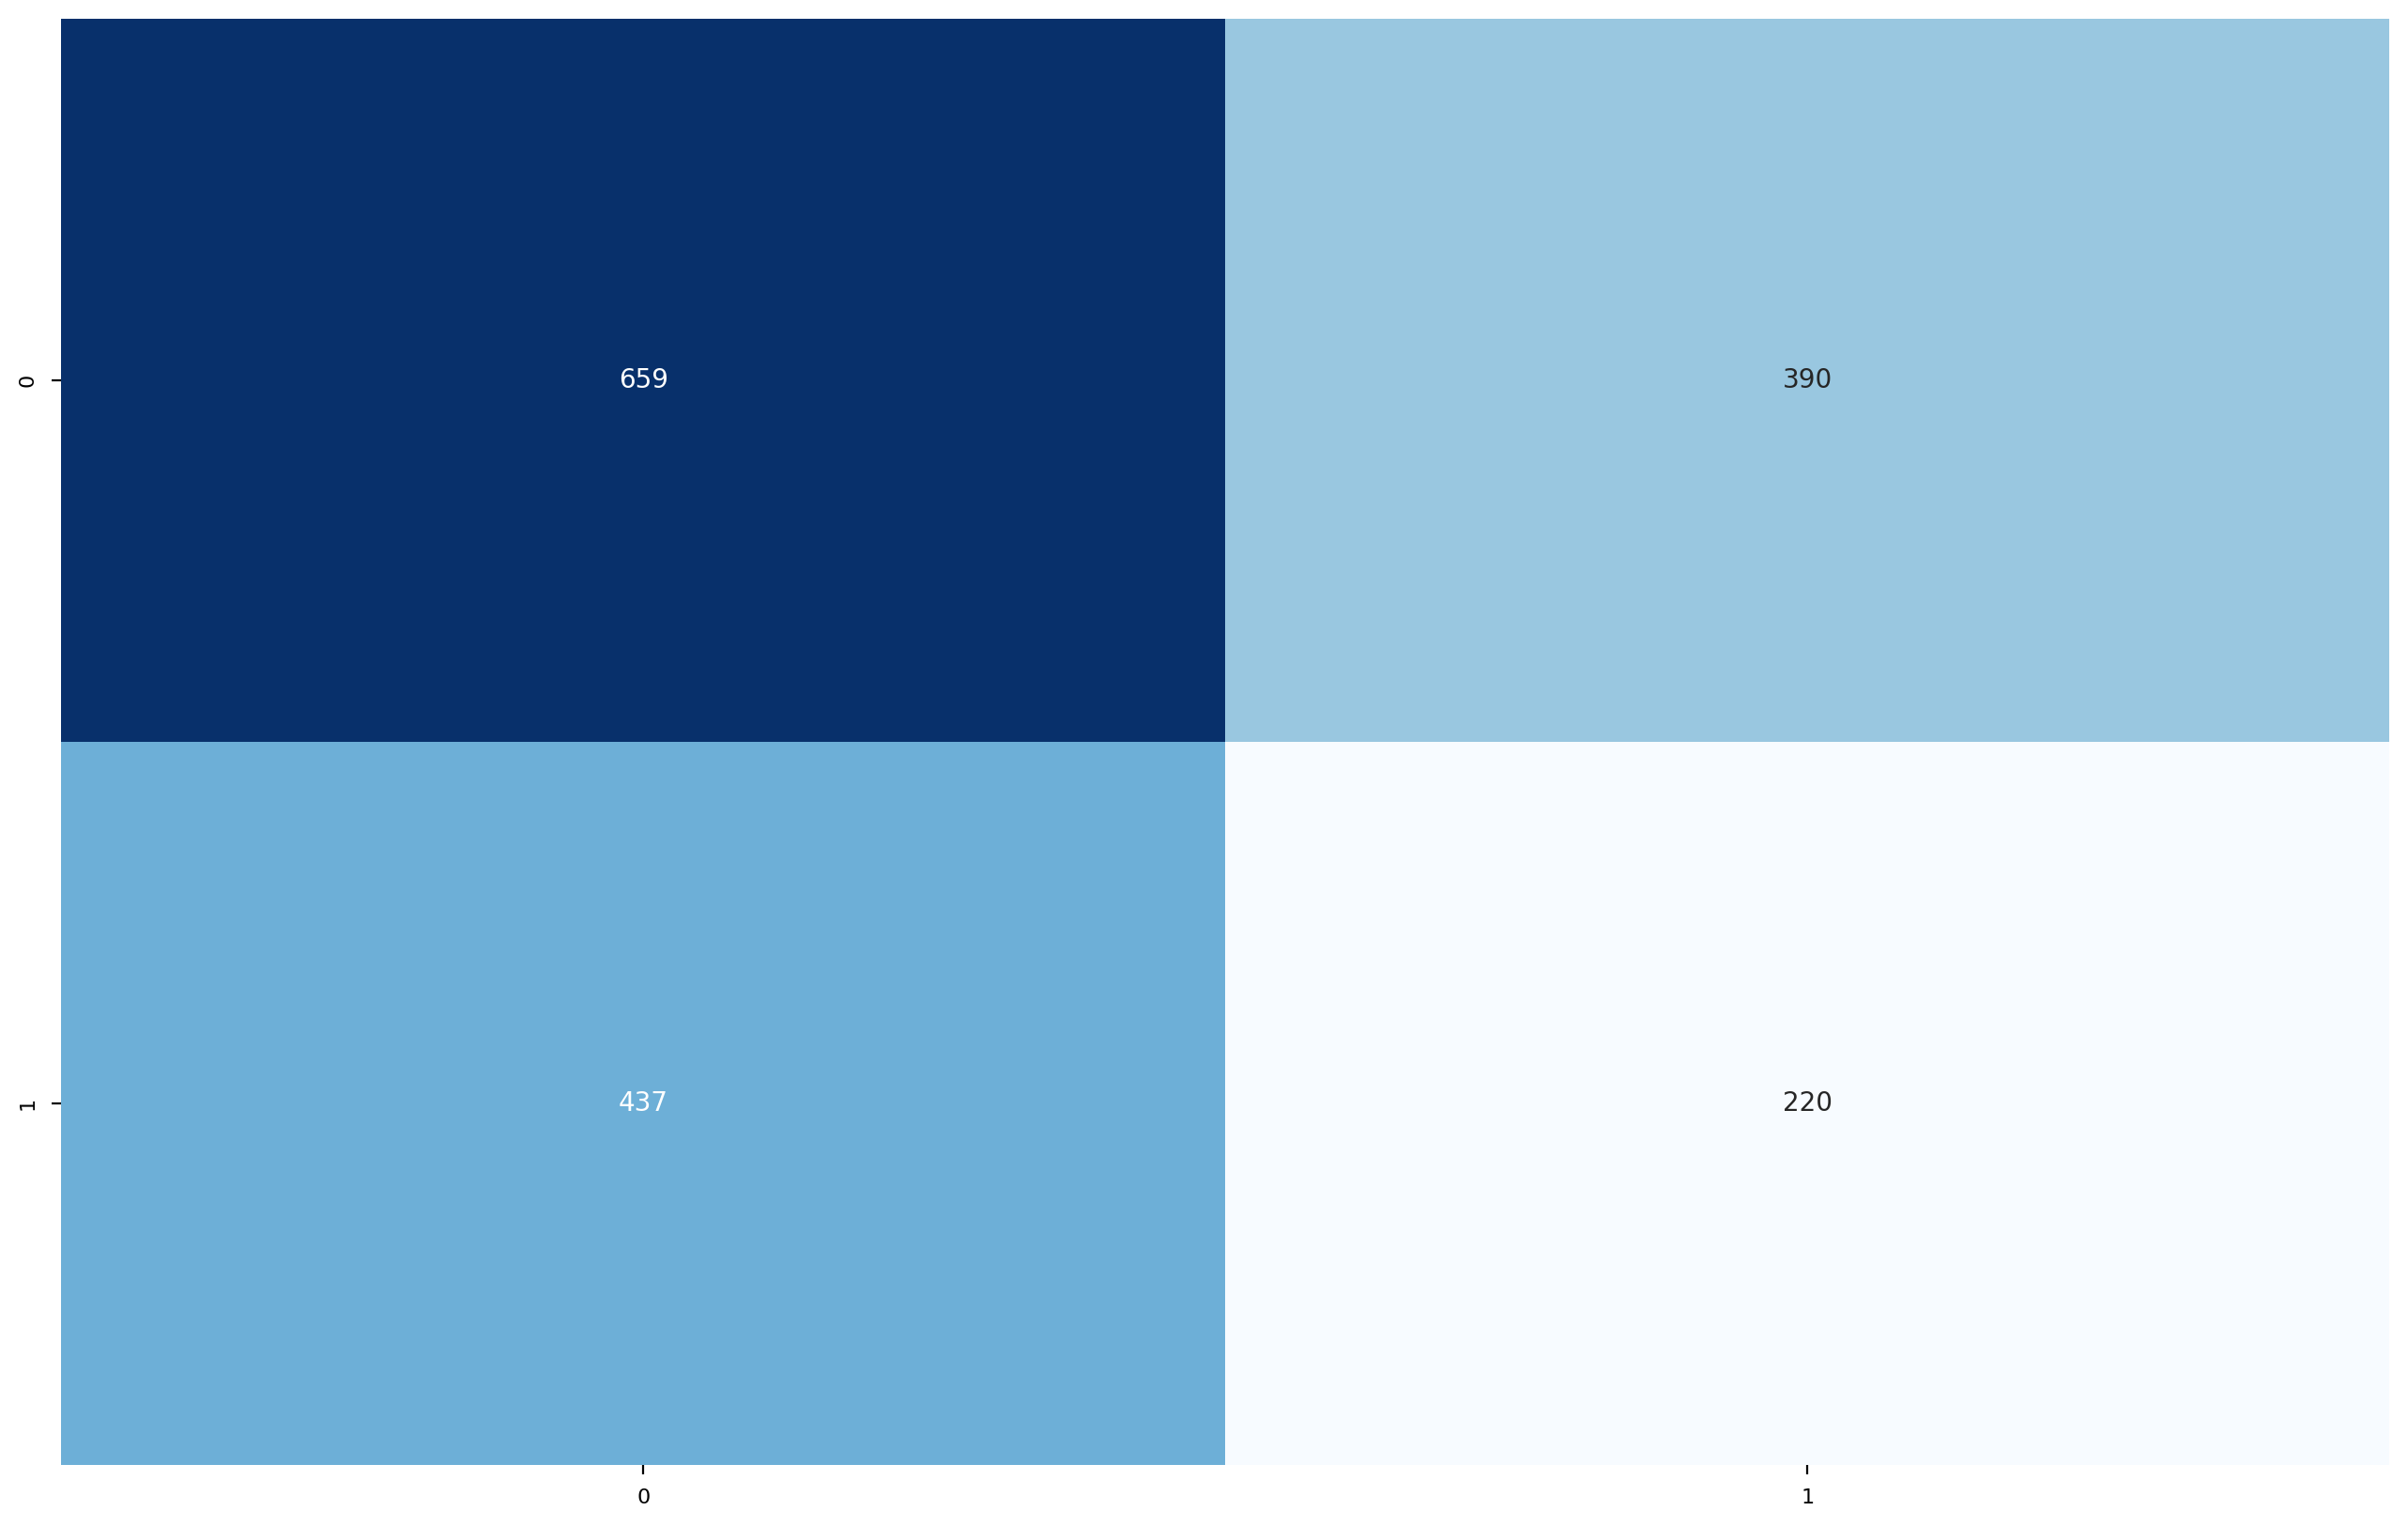

In [32]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

## Feature engineering

In [33]:
analyzed_df, info = nk.ecg_process(ecg_signal, sampling_rate=SAMPLING_RATE)
analyzed_df.keys()

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')

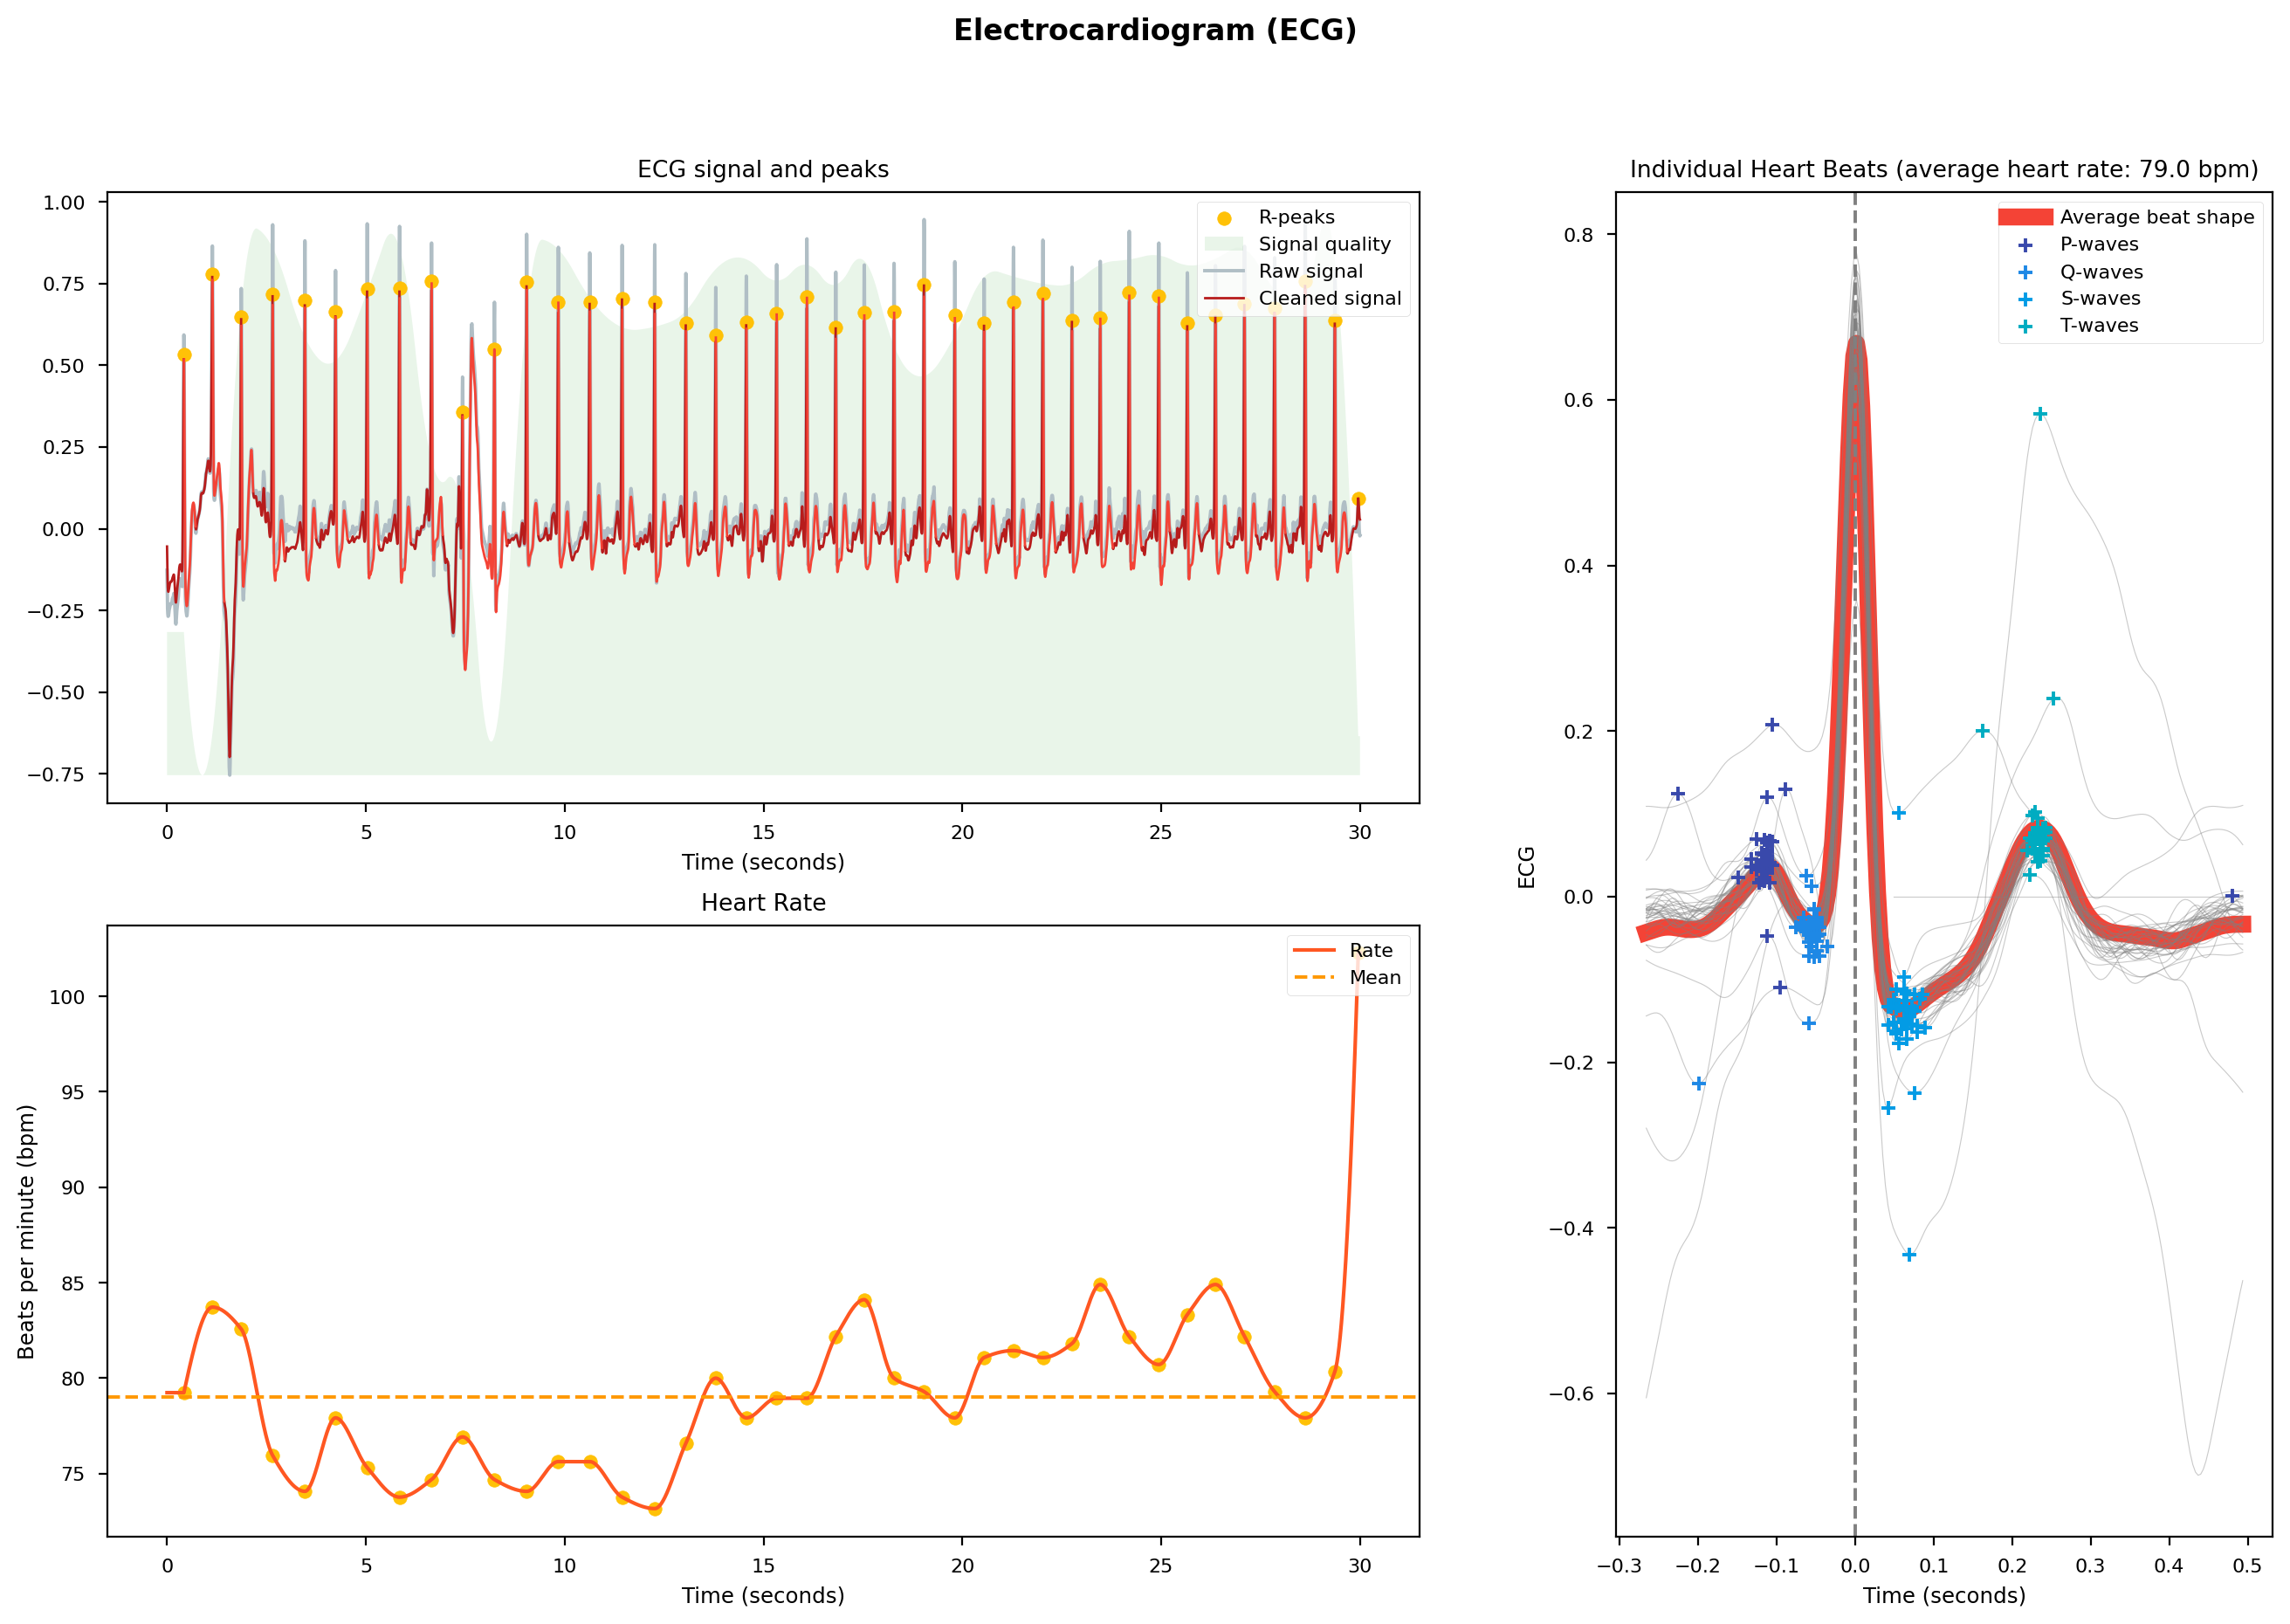

In [34]:
nk.ecg_plot(analyzed_df, info)

In [35]:
def get_signal_features(signal, sampling_rate: float):
    ecg_signal, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
    analyzed_df = ecg_signal.drop(["ECG_Phase_Completion_Ventricular", "ECG_Phase_Ventricular", "ECG_Phase_Completion_Atrial", "ECG_Phase_Atrial", "ECG_Quality"], axis=1)
    signal = signal[:, None]
    return analyzed_df.to_numpy()


In [36]:
if not os.path.exists("extracted_features.pkl"):
    processed = []
    X = df['values'].to_list()
    y = df['label']
    for i in tqdm(range(len(X))):
        try:
            processed.append((get_signal_features(X[i], SAMPLING_RATE), y[i]))
        except:
            continue

    with open("extracted_features.pkl", "wb") as handle:
        pickle.dump(processed, handle)
else:
    with open("extracted_features.pkl", "rb") as handle:
        processed = pickle.load(handle)

In [37]:
def pad_processed(X):
    for i in tqdm(range(len(X))):
        elm = X[i]
        if elm.shape[0] < 9000:
            X[i] = np.pad(elm, ((0, 9000 - elm.shape[0]), (0, 0)))
        else:
            X[i] = elm[:9000, ...]

    return X

In [38]:
X, y = [elm[0] for elm in processed], [elm[1] for elm in processed]
X = pad_processed(X)
X = np.array(X)
y = np.array(y)
y = np.array([0 if elm == "N" else 1 for elm in y])
X.shape, y.shape

100%|██████████| 8519/8519 [00:00<00:00, 35110.35it/s]


((8519, 9000, 14), (8519,))

In [39]:
B, L, C = X.shape
X = X.reshape(B, L * C)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
class_counts = np.bincount(y_train.flatten())
class_weights = dict(zip(range(2), class_counts.sum() / (2 * class_counts)))
class_weights

{0: 0.843649418172815, 1: 1.227485590778098}

In [43]:
weights = np.array([class_weights[elm] for elm in y_train])

In [44]:
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
batch_size = 256
num_batches = len(X_train) // batch_size

for epoch in range(25):
    for batch in tqdm(range(num_batches)):
        selected_indices = np.random.choice(len(X_train), size=batch_size, replace=False, p=weights/weights.sum())
        X_batch = X_train[selected_indices]
        y_batch = y_train[selected_indices]
        
        model.partial_fit(X_batch, y_batch, classes=np.unique(y))

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"Epoch {epoch} | f1: {f1}")

100%|██████████| 26/26 [00:01<00:00, 13.27it/s]


Epoch 0 | f1: 0.5575760544750894


100%|██████████| 26/26 [00:01<00:00, 13.25it/s]


Epoch 1 | f1: 0.5544914543981496


100%|██████████| 26/26 [00:01<00:00, 13.08it/s]


Epoch 2 | f1: 0.5548809330499919


100%|██████████| 26/26 [00:01<00:00, 13.38it/s]


Epoch 3 | f1: 0.5691804708706621


100%|██████████| 26/26 [00:01<00:00, 13.10it/s]


Epoch 4 | f1: 0.5606007574469666


100%|██████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 5 | f1: 0.5532905244351234


100%|██████████| 26/26 [00:01<00:00, 13.12it/s]


Epoch 6 | f1: 0.5637382386463123


100%|██████████| 26/26 [00:01<00:00, 13.31it/s]


Epoch 7 | f1: 0.5613041671041409


100%|██████████| 26/26 [00:01<00:00, 13.80it/s]


Epoch 8 | f1: 0.5703864351184986


100%|██████████| 26/26 [00:01<00:00, 13.57it/s]


Epoch 9 | f1: 0.5679406766031618


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


Epoch 10 | f1: 0.5701069426713836


100%|██████████| 26/26 [00:01<00:00, 13.05it/s]


Epoch 11 | f1: 0.5686758619540848


100%|██████████| 26/26 [00:02<00:00, 12.96it/s]


Epoch 12 | f1: 0.5702092955301732


100%|██████████| 26/26 [00:02<00:00, 12.13it/s]


Epoch 13 | f1: 0.5729342031425365


100%|██████████| 26/26 [00:02<00:00, 11.22it/s]


Epoch 14 | f1: 0.5711483236235712


100%|██████████| 26/26 [00:02<00:00, 11.95it/s]


Epoch 15 | f1: 0.5678039370217671


100%|██████████| 26/26 [00:02<00:00, 12.30it/s]


Epoch 16 | f1: 0.559369138236634


100%|██████████| 26/26 [00:02<00:00, 11.92it/s]


Epoch 17 | f1: 0.5652900506525678


100%|██████████| 26/26 [00:02<00:00, 10.80it/s]


Epoch 18 | f1: 0.5689798833472206


100%|██████████| 26/26 [00:02<00:00, 12.13it/s]


Epoch 19 | f1: 0.5676463433363714


100%|██████████| 26/26 [00:02<00:00, 12.18it/s]


Epoch 20 | f1: 0.564956582807121


100%|██████████| 26/26 [00:02<00:00, 12.33it/s]


Epoch 21 | f1: 0.5611045589491237


100%|██████████| 26/26 [00:01<00:00, 13.11it/s]


Epoch 22 | f1: 0.5590962944805327


100%|██████████| 26/26 [00:02<00:00, 12.79it/s]


Epoch 23 | f1: 0.5631012476296626


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


Epoch 24 | f1: 0.5554873457997241


In [45]:
y_pred = model.predict(X_test)

Accuracy: 0.5980046948356808
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1011
           1       0.51      0.35      0.42       693

    accuracy                           0.60      1704
   macro avg       0.57      0.56      0.56      1704
weighted avg       0.58      0.60      0.58      1704



<Axes: >

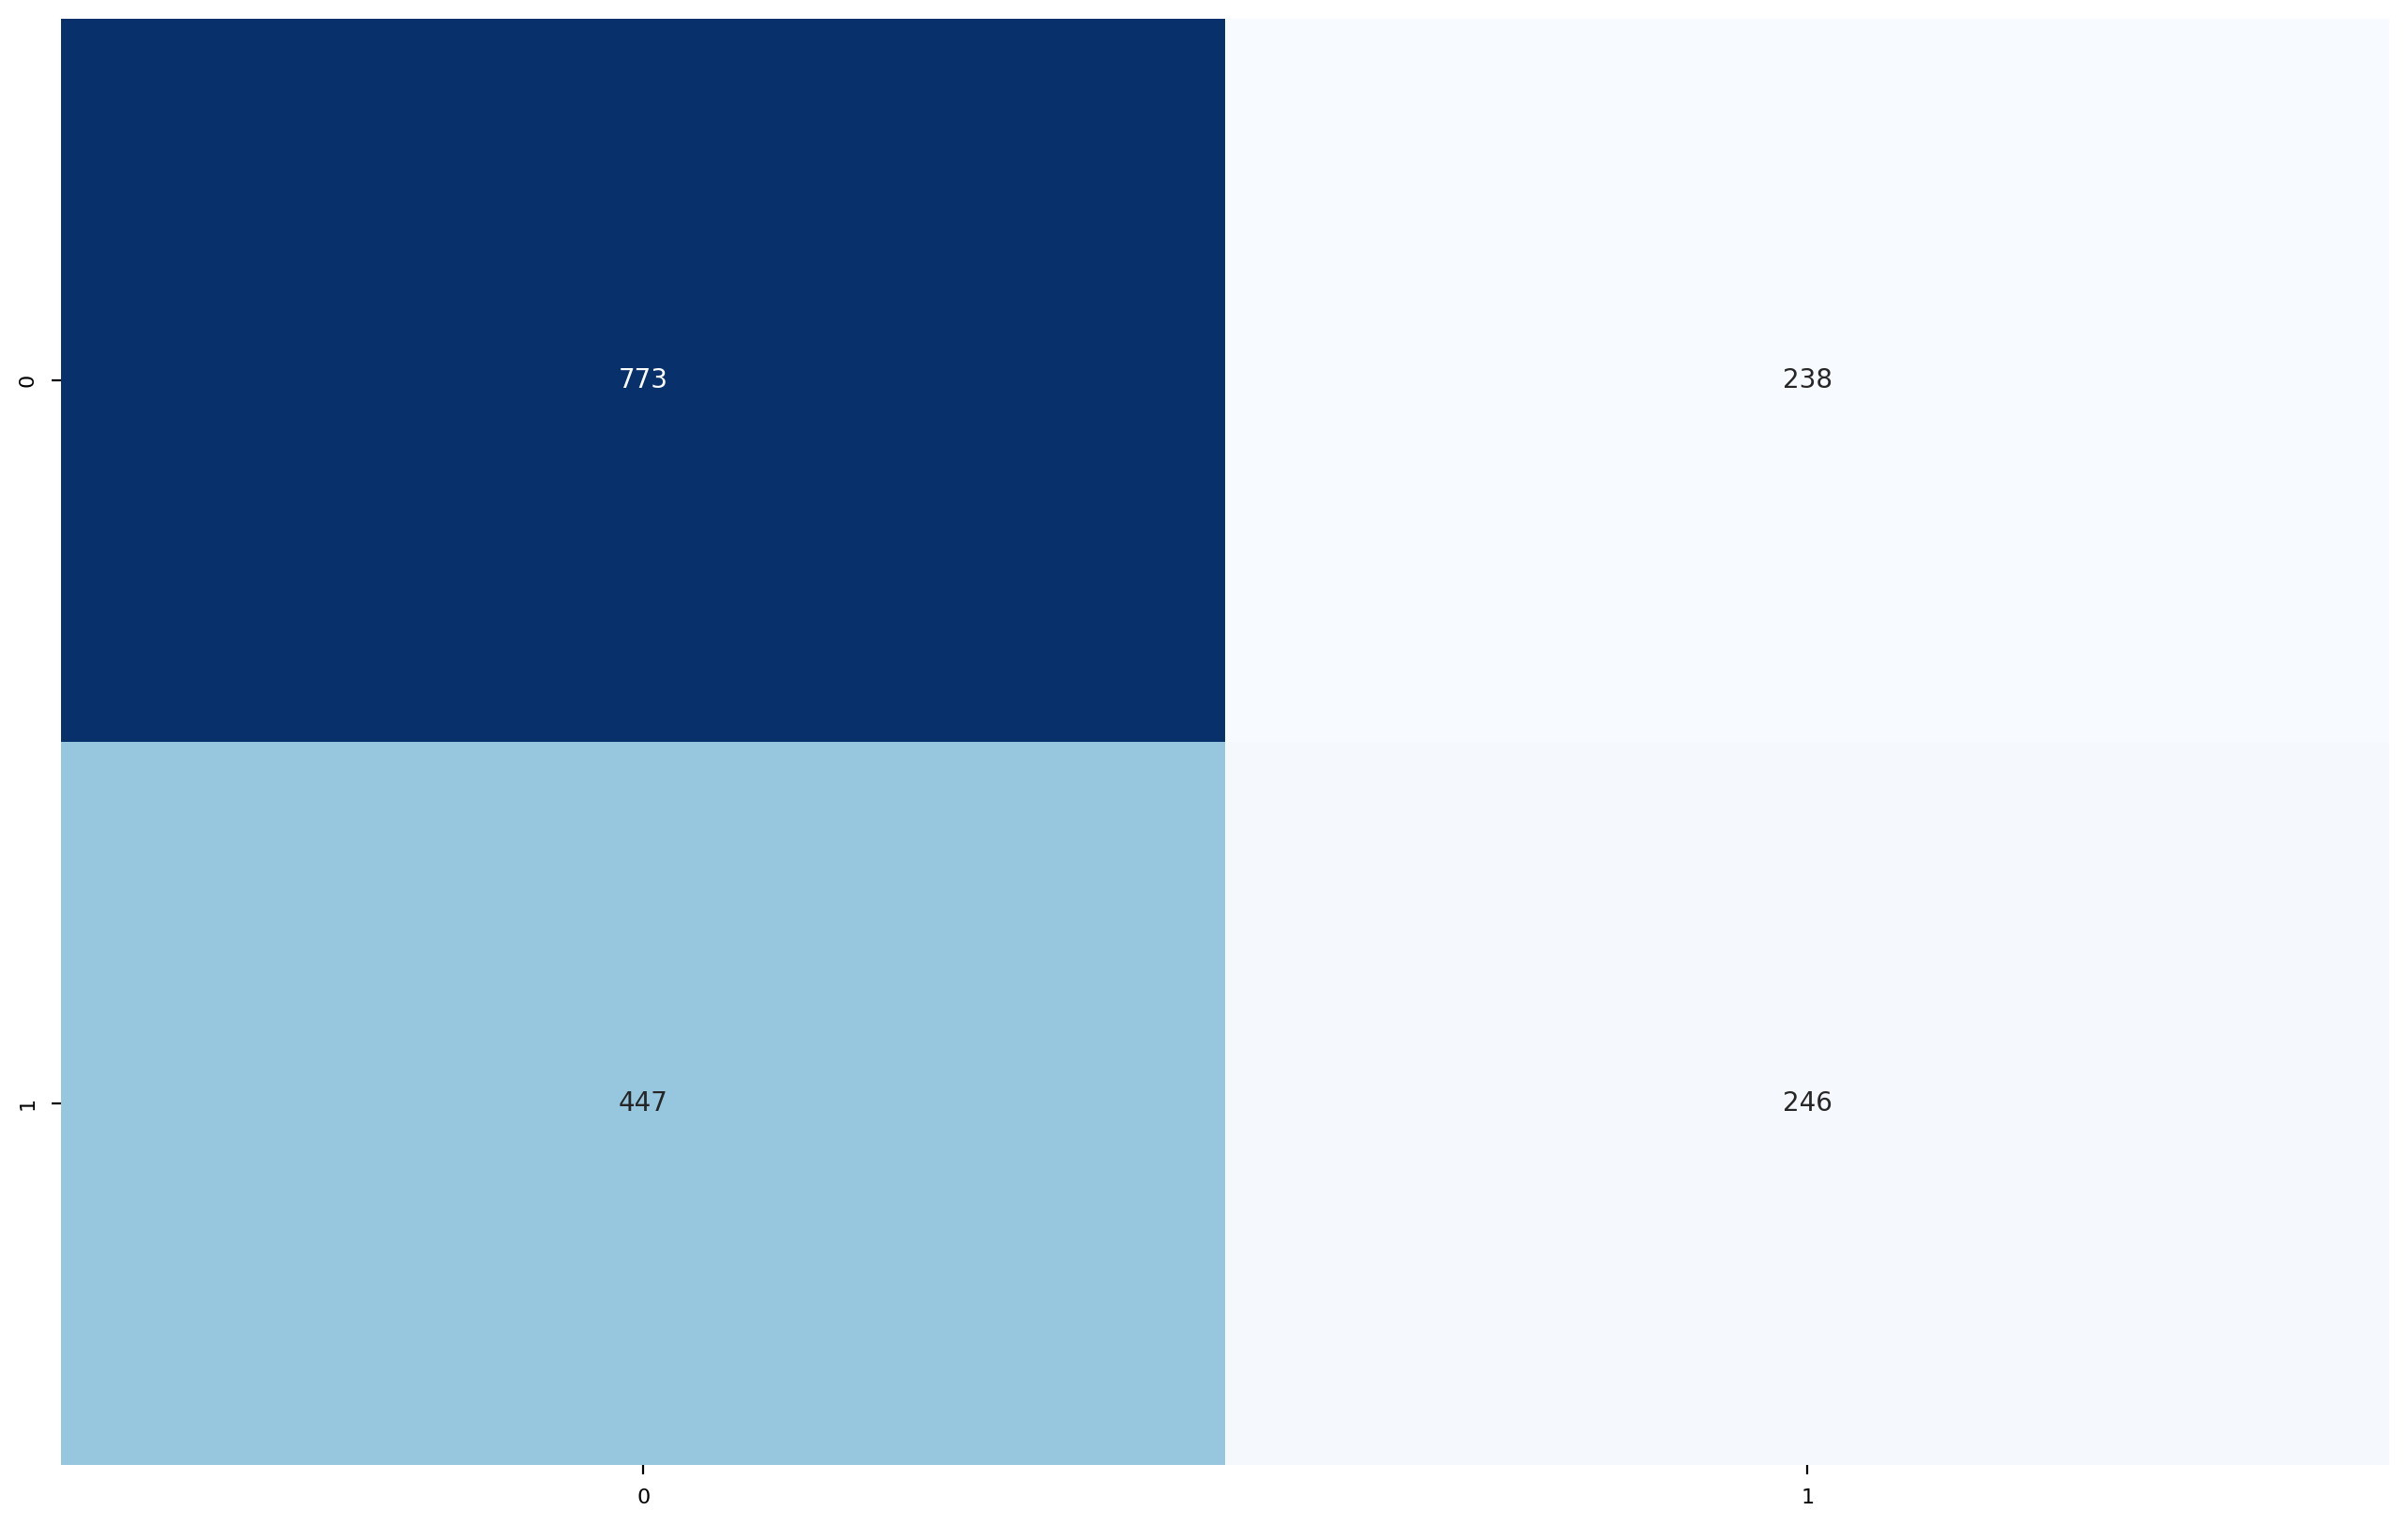

In [46]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

## XGBoost

In [47]:
params = {
    'objective': 'multi:softmax',
    'num_class': 2,
    'eval_metric': 'mlogloss',
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'scale_pos_weight': weights,
}

model = xgb.XGBClassifier(**params)

In [48]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [49]:
y_pred = model.predict(X_test)

Accuracy: 0.732981220657277
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      1011
           1       0.80      0.45      0.58       693

    accuracy                           0.73      1704
   macro avg       0.76      0.69      0.69      1704
weighted avg       0.75      0.73      0.71      1704



<Axes: >

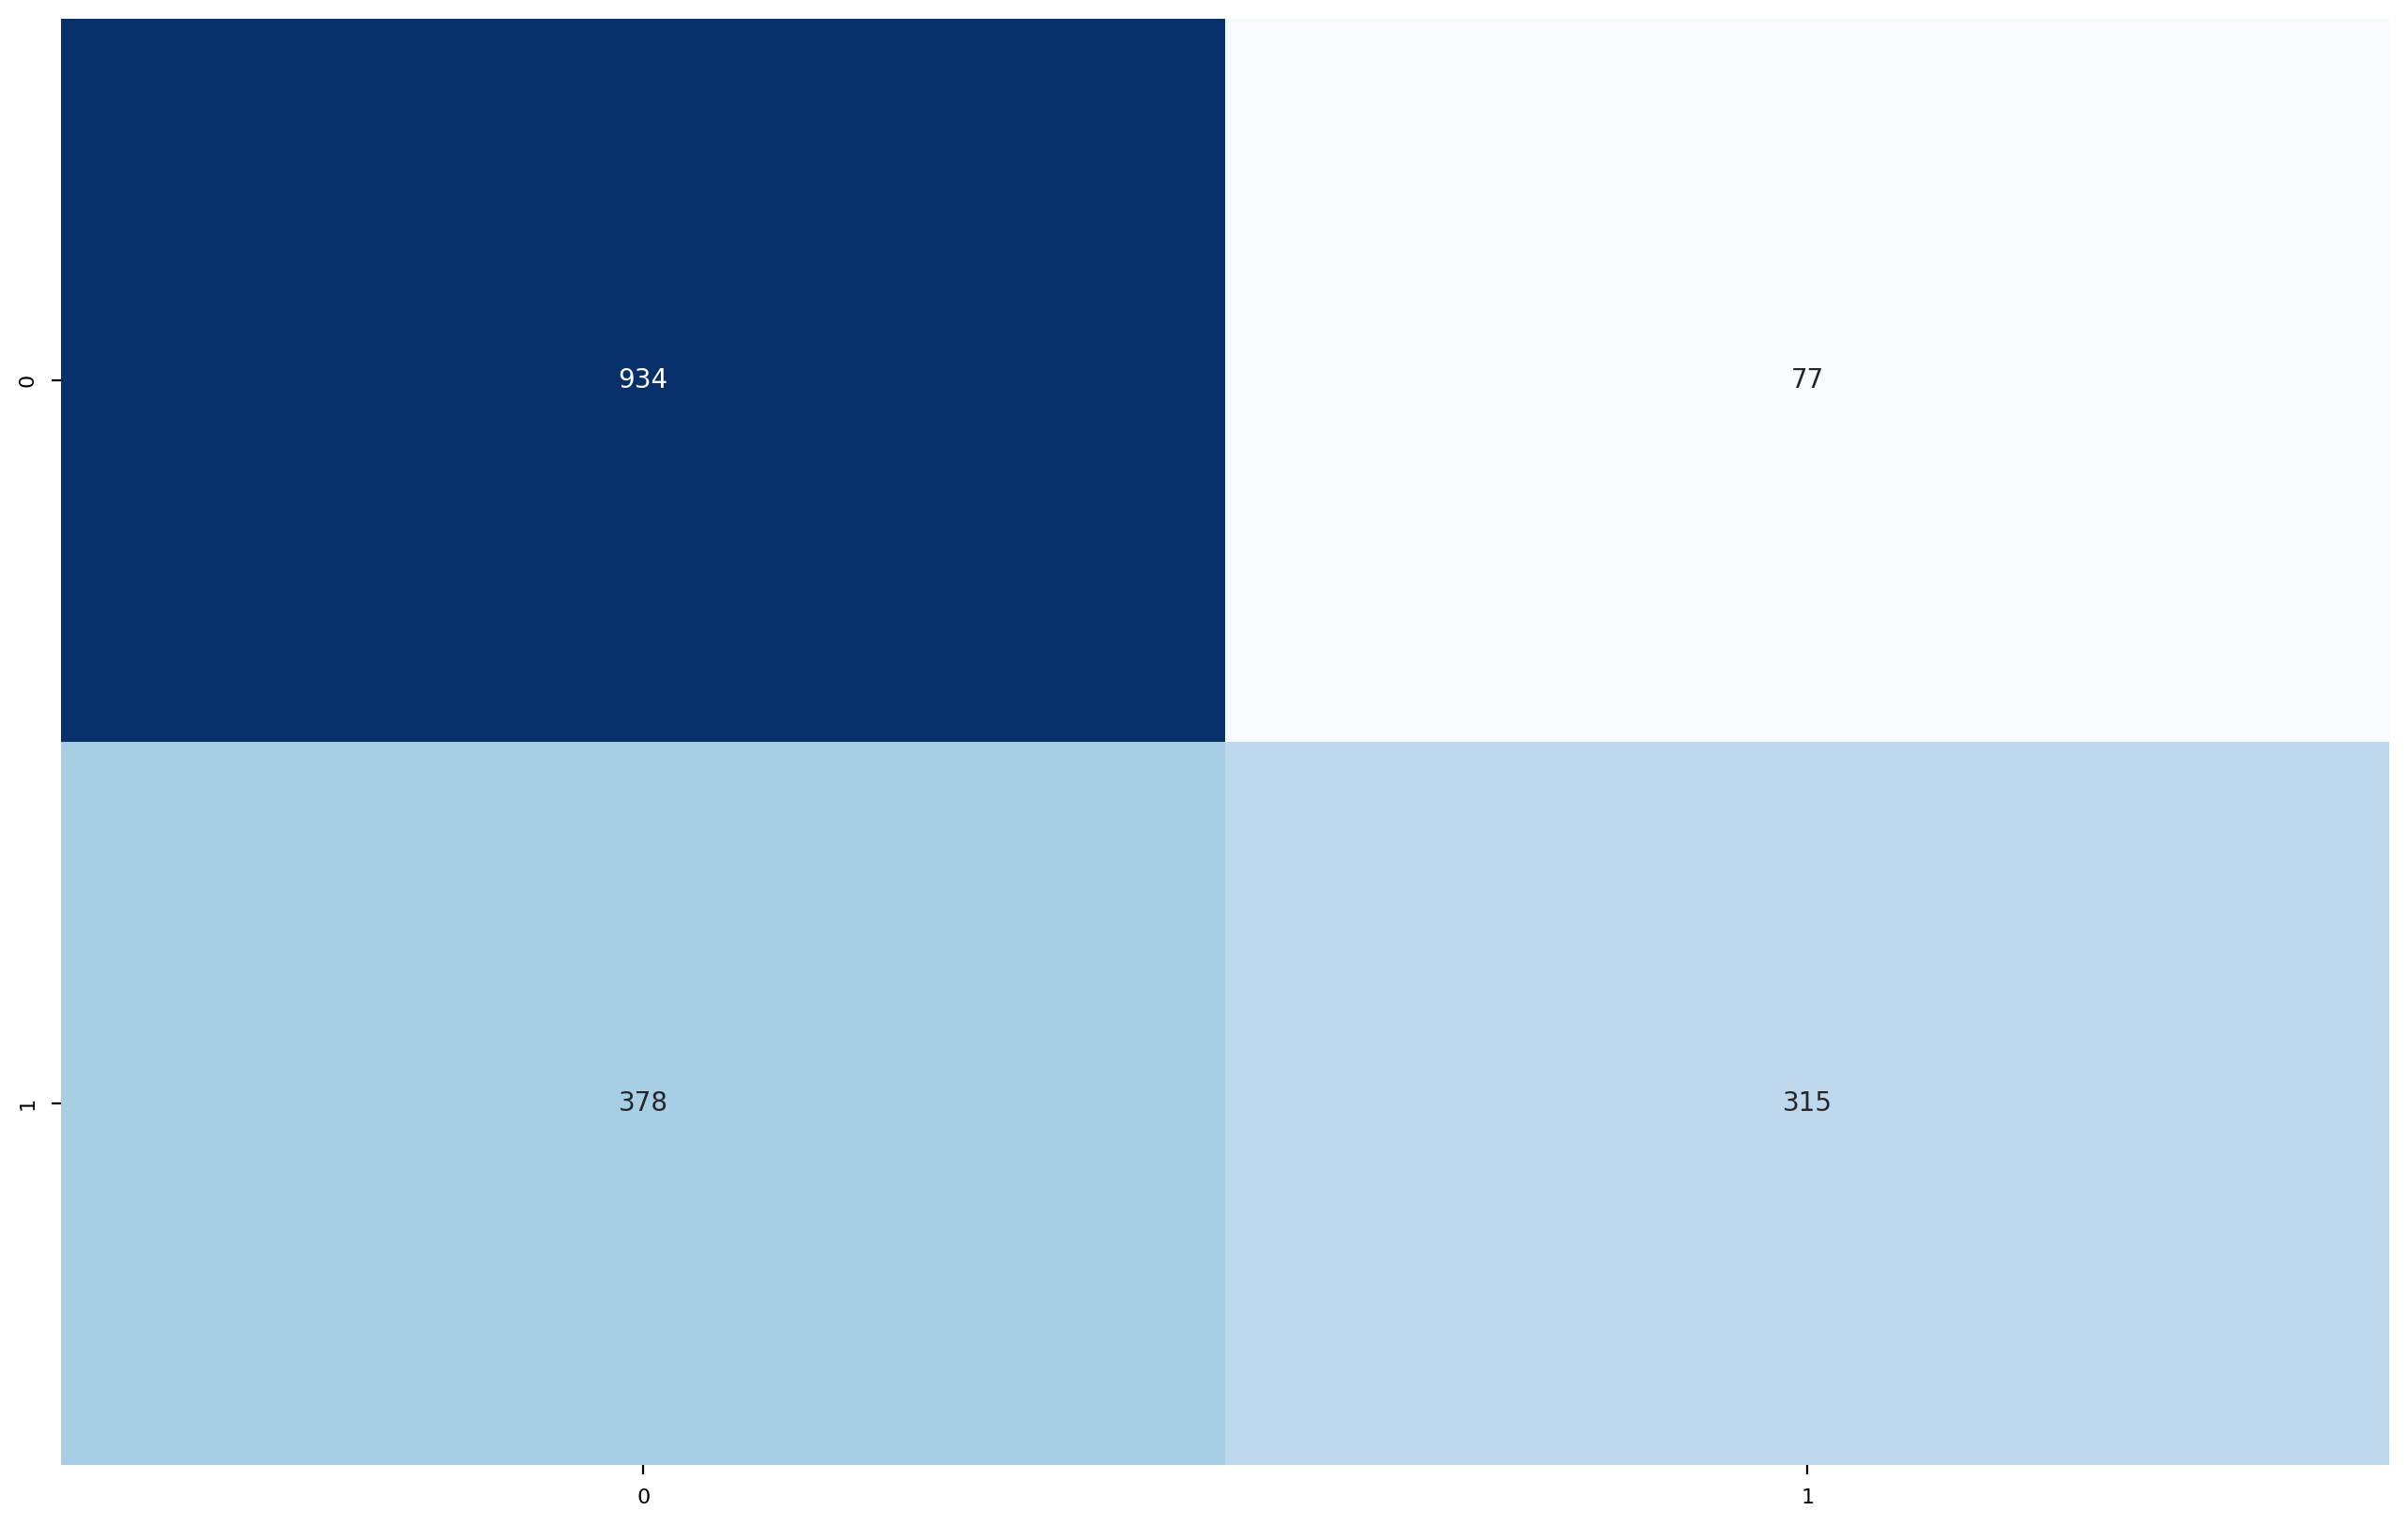

In [50]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

## LSTM time

In [51]:
from sklearn.preprocessing import StandardScaler

device = "cpu"

class ECGLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ECGLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 3, kernel_size=3, stride=3)
        self.conv2 = nn.Conv1d(3, 9, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm1d(9)
        self.conv3 = nn.Conv1d(9, 9, kernel_size=3, stride=2)
        self.conv4 = nn.Conv1d(9, 27, kernel_size=3, stride=2)
        self.conv5 = nn.Conv1d(27, 27, kernel_size=3, stride=2)
        self.conv6 = nn.Conv1d(27, 81, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm1d(81)
        self.lstm = nn.LSTM(81, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(num_layers * 2 * hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        output, (hn, cn) = self.lstm(x)
        cn = cn.permute(1, 0, 2).reshape(B, -1)
        out = self.fc1(cn)
        out = F.relu(self.bn3(out))
        # out = self.dropout(out)
        out = self.fc2(out)
        
        return out
        
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()

        self.seq = pad_signals(df['values'].to_list())
        self.labels = df["label"]

        # self.le = preprocessing.LabelEncoder()
        # self.le.fit(np.unique(labels))
        # self.labels = self.le.transform(labels)

        self.scaler = StandardScaler()
        self.scaler.fit(self.seq)
        self.seq = self.scaler.transform(self.seq)
        
        
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        seq, label = self.seq[idx], self.labels[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

dataset = ECGDataset(df)
len(dataset), dataset[3]

100%|██████████| 8528/8528 [00:02<00:00, 3067.06it/s]


(8528,
 (tensor([1.3219, 1.3176, 1.3202,  ..., 0.5458, 0.0617, 0.0915]), tensor(1)))

In [52]:
indexes = np.arange(len(dataset))
ind_train, ind_test, _, _ = train_test_split(
    indexes, np.zeros(indexes.shape[0]), test_size=0.2, random_state=42)

In [53]:
train_dataset = torch.utils.data.Subset(dataset, indices=ind_train)
test_dataset = torch.utils.data.Subset(dataset, indices=ind_test)

In [54]:
labels = np.array([train_dataset[i][1].item() for i in range(len(train_dataset))])
class_weights = 1.0 / np.bincount(labels)
weights = class_weights[labels]
generator = torch.Generator()
generator.manual_seed(42)
weighted_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True, generator=generator)

In [55]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False, sampler=weighted_sampler) # sampler=weighted_sampler
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
input_size = 1
hidden_size = 256
num_layers = 2
output_size = 2
learning_rate = 5e-3
num_epochs = 50

device = torch.device("mps")

model = ECGLSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [57]:
model

ECGLSTM(
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(3,))
  (conv2): Conv1d(3, 9, kernel_size=(3,), stride=(2,))
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(9, 9, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(9, 27, kernel_size=(3,), stride=(2,))
  (conv5): Conv1d(27, 27, kernel_size=(3,), stride=(2,))
  (conv6): Conv1d(27, 81, kernel_size=(3,), stride=(2,))
  (bn2): BatchNorm1d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(81, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [58]:
sum([param.nelement() for param in model.parameters()])

2544804

In [59]:
@torch.inference_mode()
def eval_model(model, test_loader, device: str = "mps", print_res: bool = False):
    model.eval()
    device = torch.device(device)

    criterion = nn.CrossEntropyLoss()

    labels, predictions = [], []
    test_loss = 0.0
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        test_output = model(data)

        loss = criterion(test_output, target)
    
        _, predicted_labels = torch.max(test_output, 1)

        predictions.extend(list(predicted_labels.cpu().numpy()))
        labels.extend(list(target.cpu().numpy()))
        test_loss += loss.item()

    test_loss = epoch_loss / len(test_loader)

    accuracy = accuracy_score(labels, predictions)
    conf_matrix = confusion_matrix(labels, predictions)
    class_report = classification_report(labels, predictions)

    if print_res:
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{class_report}")
        print(conf_matrix)

    return accuracy, test_loss

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=7, min_delta=0.1)

In [60]:
model.train()

ECGLSTM(
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(3,))
  (conv2): Conv1d(3, 9, kernel_size=(3,), stride=(2,))
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(9, 9, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(9, 27, kernel_size=(3,), stride=(2,))
  (conv5): Conv1d(27, 27, kernel_size=(3,), stride=(2,))
  (conv6): Conv1d(27, 81, kernel_size=(3,), stride=(2,))
  (bn2): BatchNorm1d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(81, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [61]:
train_losses, val_losses = [], []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for (data, target) in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)    

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    ta, tl = eval_model(model, test_loader, device=device, print_res=False)

    scheduler.step(tl)
    
    print(f"Epoch {epoch}: ", epoch_loss / len(train_loader), tl, scheduler.optimizer.param_groups[0]['lr'])
    val_acc.append(ta)
    val_losses.append(tl)

    if early_stopper.early_stop(tl):   
        print("Early stopping: breaking")
        break

100%|██████████| 7/7 [00:00<00:00, 10.35it/s]


Epoch 0:  0.7647047363794767 2.8403318779809132 0.005


100%|██████████| 7/7 [00:00<00:00, 10.78it/s]


Epoch 1:  0.6870127595387973 2.551761678286961 0.005


100%|██████████| 7/7 [00:00<00:00, 11.01it/s]


Epoch 2:  0.6742275288471808 2.504273678575243 0.005


100%|██████████| 7/7 [00:00<00:00, 11.11it/s]


Epoch 3:  0.6293084850678077 2.3374315159661427 0.005


100%|██████████| 7/7 [00:00<00:00, 10.89it/s]


Epoch 4:  0.5391395733906672 2.00251841545105 0.005


100%|██████████| 7/7 [00:00<00:00, 11.04it/s]


Epoch 5:  0.4457805087933174 1.6557561755180359 0.005


100%|██████████| 7/7 [00:00<00:00, 10.99it/s]


Epoch 6:  0.37807062382881457 1.404262317078454 0.005


100%|██████████| 7/7 [00:00<00:00, 10.65it/s]


Epoch 7:  0.2936513630243448 1.0907050626618522 0.005


100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


Epoch 8:  0.23785815617212883 0.8834731514964785 0.005


100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Epoch 9:  0.17024696790255034 0.6323458807809013 0.005


100%|██████████| 7/7 [00:00<00:00, 10.89it/s]


Epoch 10:  0.1246534981406652 0.4629987073796136 0.005


100%|██████████| 7/7 [00:00<00:00,  9.90it/s]


Epoch 11:  0.11165075777814938 0.4147028146045549 0.005


100%|██████████| 7/7 [00:00<00:00, 10.79it/s]


Epoch 12:  0.061202009136860185 0.22732174822262355 0.005


100%|██████████| 7/7 [00:00<00:00, 10.23it/s]


Epoch 13:  0.07116201433997887 0.2643160532627787 0.005


100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


Epoch 14:  0.05957295365918141 0.22127097073410237 0.005


100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


Epoch 15:  0.03230972960591316 0.12000756710767746 0.005


100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


Epoch 16:  0.04102407299125424 0.15237512825323002 0.005


100%|██████████| 7/7 [00:00<00:00,  9.84it/s]


Epoch 17:  0.05106869454567249 0.18968372259821212 0.005


100%|██████████| 7/7 [00:00<00:00, 10.03it/s]


Epoch 18:  0.03511259454087569 0.13041820829468115 0.005


100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


Epoch 19:  0.02329880205126336 0.0865384076189782 0.005


100%|██████████| 7/7 [00:00<00:00,  9.88it/s]


Epoch 20:  0.015394489352519695 0.05717953188078744 0.005


100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


Epoch 21:  0.011876737179521184 0.044113595238221545 0.005


100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


Epoch 22:  0.010865564538667409 0.0403578111436218 0.005


100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


Epoch 23:  0.01869712244325246 0.06944645478922341 0.005


100%|██████████| 7/7 [00:00<00:00,  9.37it/s]


Epoch 24:  0.023941598205755536 0.08892593619280628 0.005


100%|██████████| 7/7 [00:00<00:00,  9.80it/s]


Epoch 25:  0.026435839710757136 0.09819026178281222 0.005


100%|██████████| 7/7 [00:00<00:00, 10.31it/s]


Epoch 26:  0.02566913515329361 0.09534250199794769 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.09it/s]


Epoch 27:  0.027624368989983432 0.10260479910565275 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


Epoch 28:  0.006383492038227045 0.02371011328484331 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.05it/s]


Epoch 29:  0.004962781148676116 0.018433187123654143 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.04it/s]


Epoch 30:  0.001949403690210042 0.007240642277923014 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.96it/s]


Epoch 31:  0.0016102197584517014 0.005980816245677748 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.91it/s]


Epoch 32:  0.001473924145102501 0.005474575396095004 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.91it/s]


Epoch 33:  0.0010735192246591817 0.0039873571201626745 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.09it/s]


Epoch 34:  0.0009624328701577794 0.003574750660586038 0.0005


100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 35:  0.0010081334442545015 0.0037444956500881483 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.53it/s]


Epoch 36:  0.0010247091525413382 0.0038060625665821135 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.12it/s]


Epoch 37:  0.0007535591128264339 0.0027989338476410402 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.24it/s]


Epoch 38:  0.0007689277968333604 0.002856017531095339 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.75it/s]


Epoch 39:  0.0006659151303420702 0.0024733990555562612 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.72it/s]


Epoch 40:  0.0006345746839472738 0.002356991683232731 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.91it/s]


Epoch 41:  0.0006698792175694297 0.0024881228081150247 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


Epoch 42:  0.0005699387172801205 0.0021169152356118764 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


Epoch 43:  0.000526193104003771 0.0019544315291568637 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


Epoch 44:  0.0005543970927157296 0.002059189201515567 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.91it/s]


Epoch 45:  0.000709354642962213 0.0026347458167167914 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


Epoch 46:  0.0005340694333426654 0.0019836864667013288 0.0005


100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch 47:  0.00041114769835705654 0.001527120022469067 0.0005


100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Epoch 48:  0.0003628306524031079 0.0013476567089258293 0.0005


100%|██████████| 7/7 [00:00<00:00, 10.08it/s]

Epoch 49:  0.00042171698274055065 0.0015663773644649024 0.0005


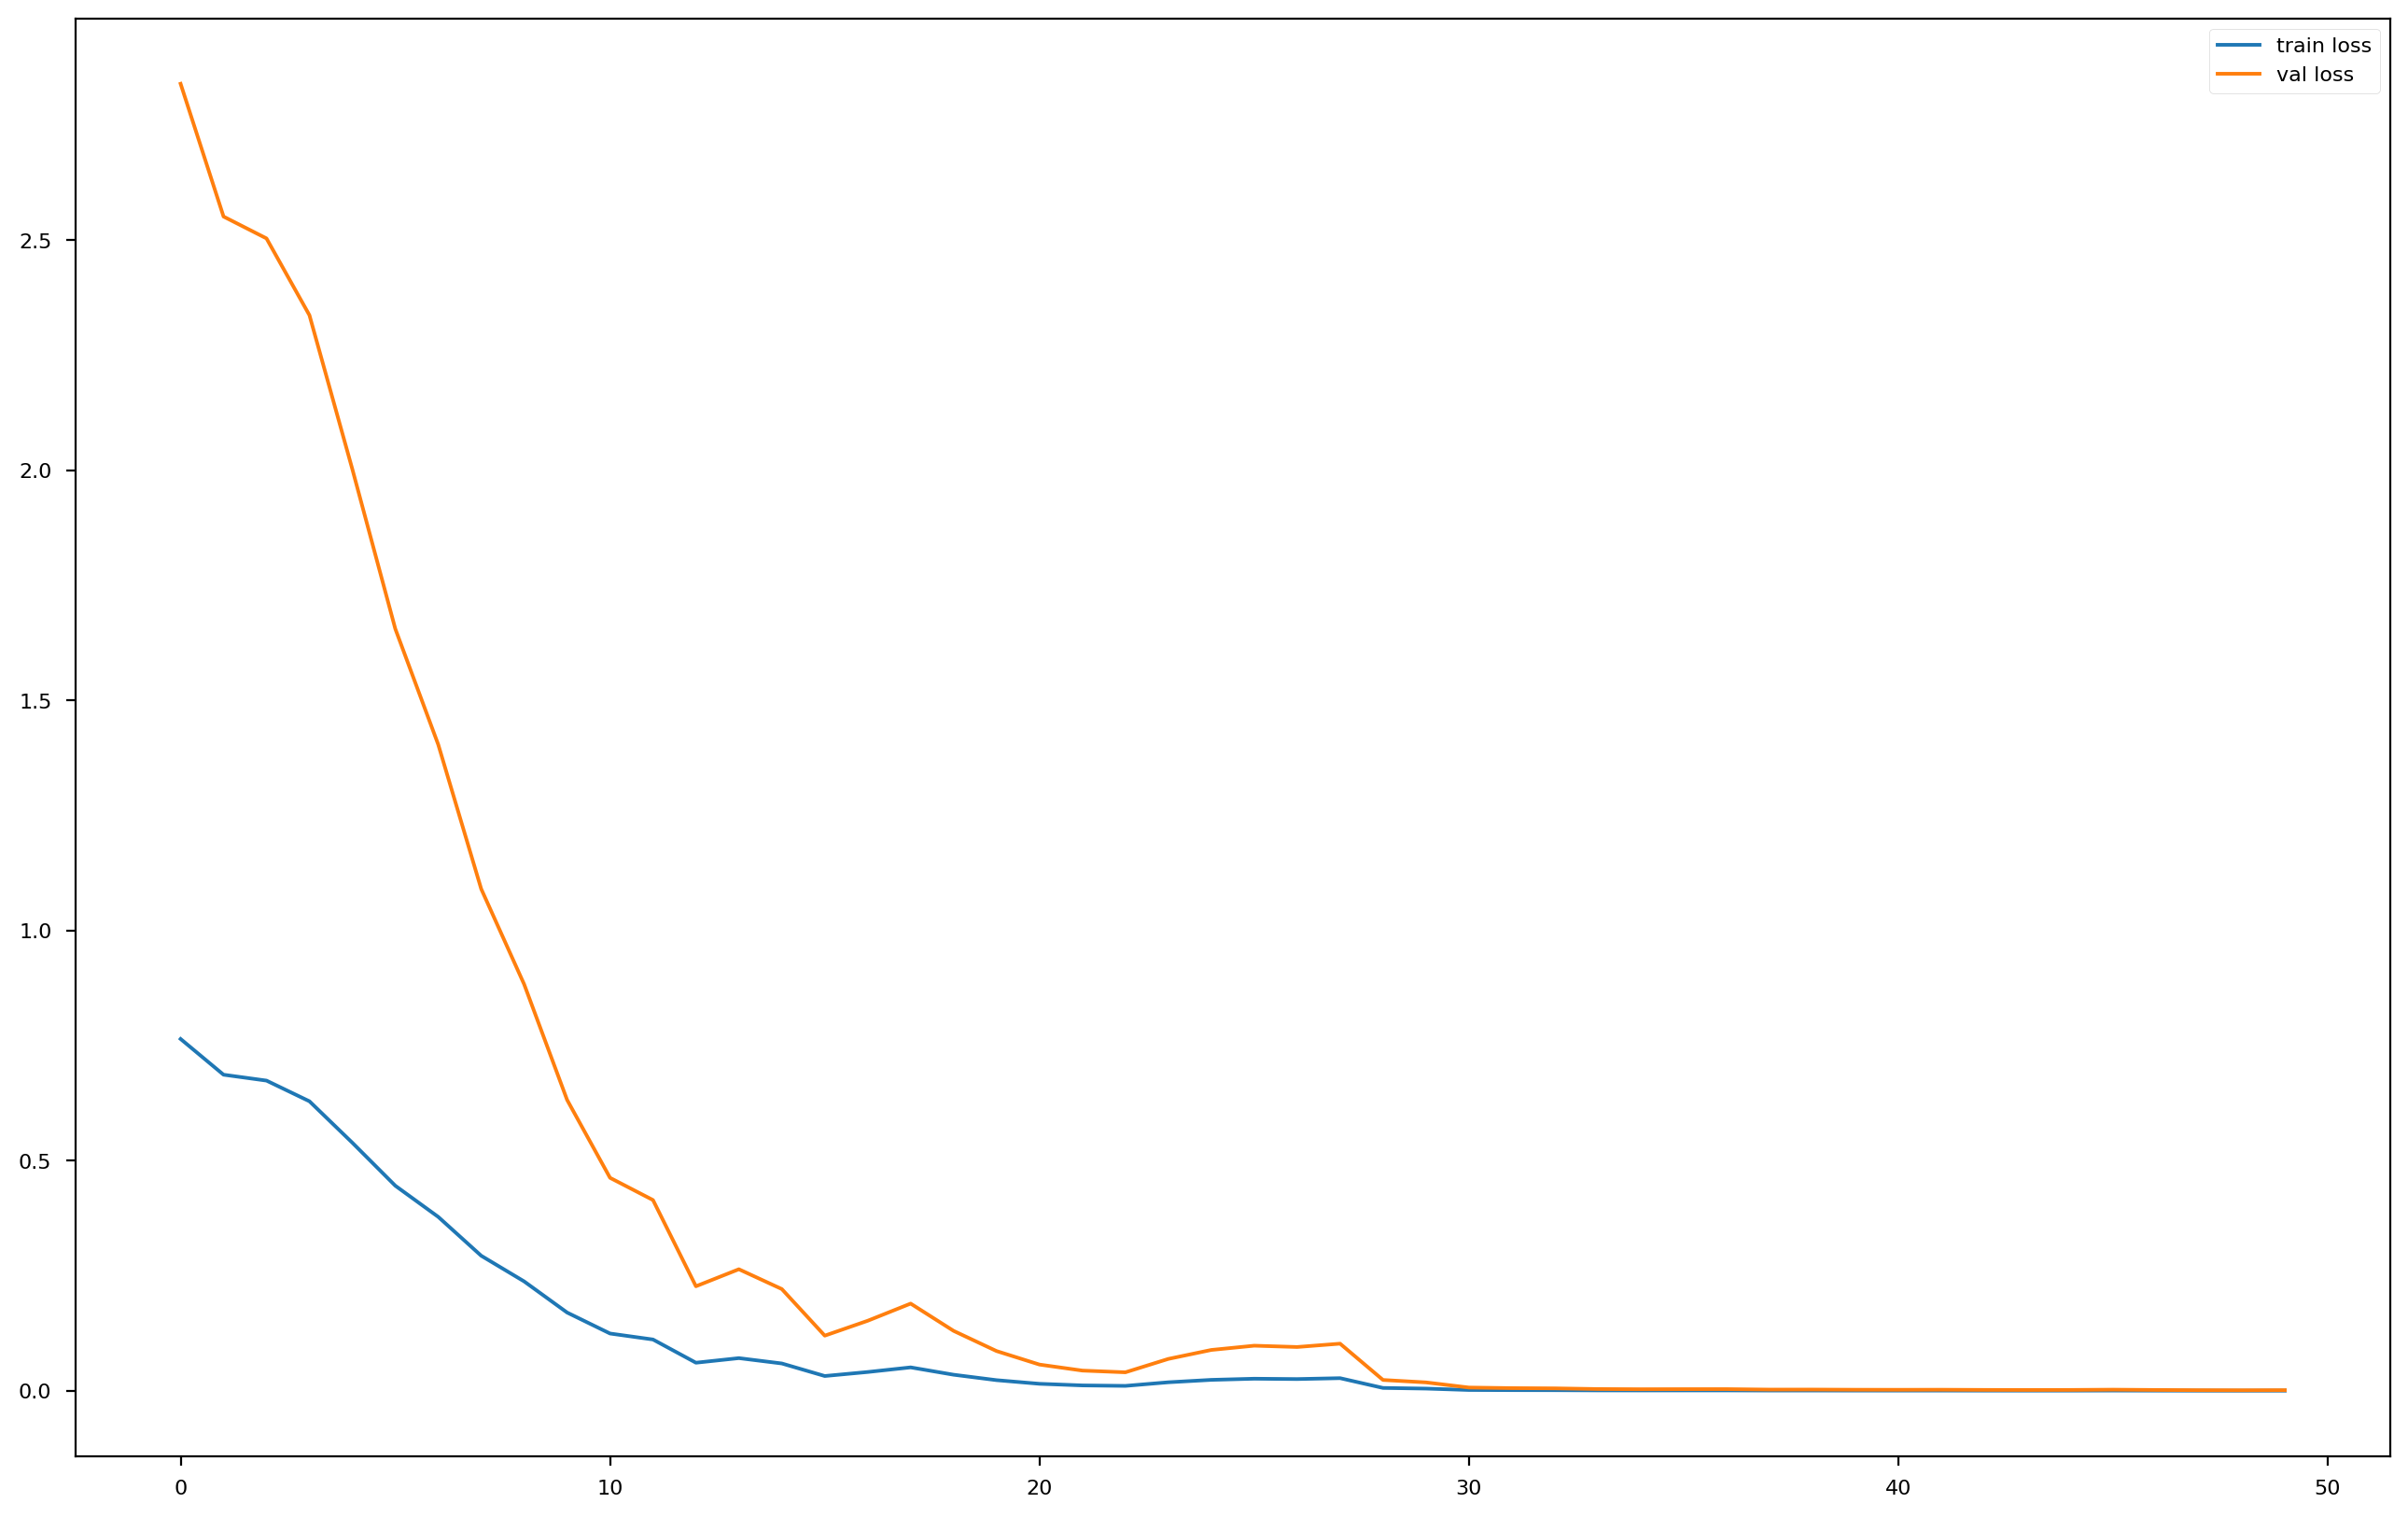

In [62]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()

In [63]:
eval_model(model, test_loader, device=device, print_res=True)

100%|██████████| 7/7 [00:00<00:00, 10.64it/s]

Accuracy: 0.7713950762016413
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1049
           1       0.72      0.67      0.69       657

    accuracy                           0.77      1706
   macro avg       0.76      0.75      0.75      1706
weighted avg       0.77      0.77      0.77      1706

[[879 170]
 [220 437]]


(0.7713950762016413, 0.0015663773644649024)

## Unsupervised CNNs

In [64]:
def signal_to_images(signal, sampling_rate: float = SAMPLING_RATE, method: str = "cwt"):
    widths = np.arange(1, 64)

    epochs = nk.ecg_segment(signal, rpeaks=None, sampling_rate=sampling_rate, show=False)
    epochs_numbers = epochs.keys()
    images = []
    for en in epochs_numbers:
        try:
            epoch = epochs[en]["Signal"]

            time = epoch.index
            time -= time[0]

            if method == "cwt":
                cwt_result = cwt(epoch.values, ricker, widths)
                image = cwt_to_img(cwt_result, time)
            elif method == "spec":
                frequencies, times, Sxx = spectrogram(epoch.values, fs=SAMPLING_RATE, nperseg=32, noverlap=0.5)
                image = spectrogram_to_img(frequencies, times, Sxx)
            else:
                raise NotImplemented
            plt.close()
        except Exception as ex:
            print(ex)
            continue

        images.append(image)

    return np.stack(images)
        

In [65]:
epochs = nk.ecg_segment(ecg_signal, rpeaks=None, sampling_rate=250, show=False)

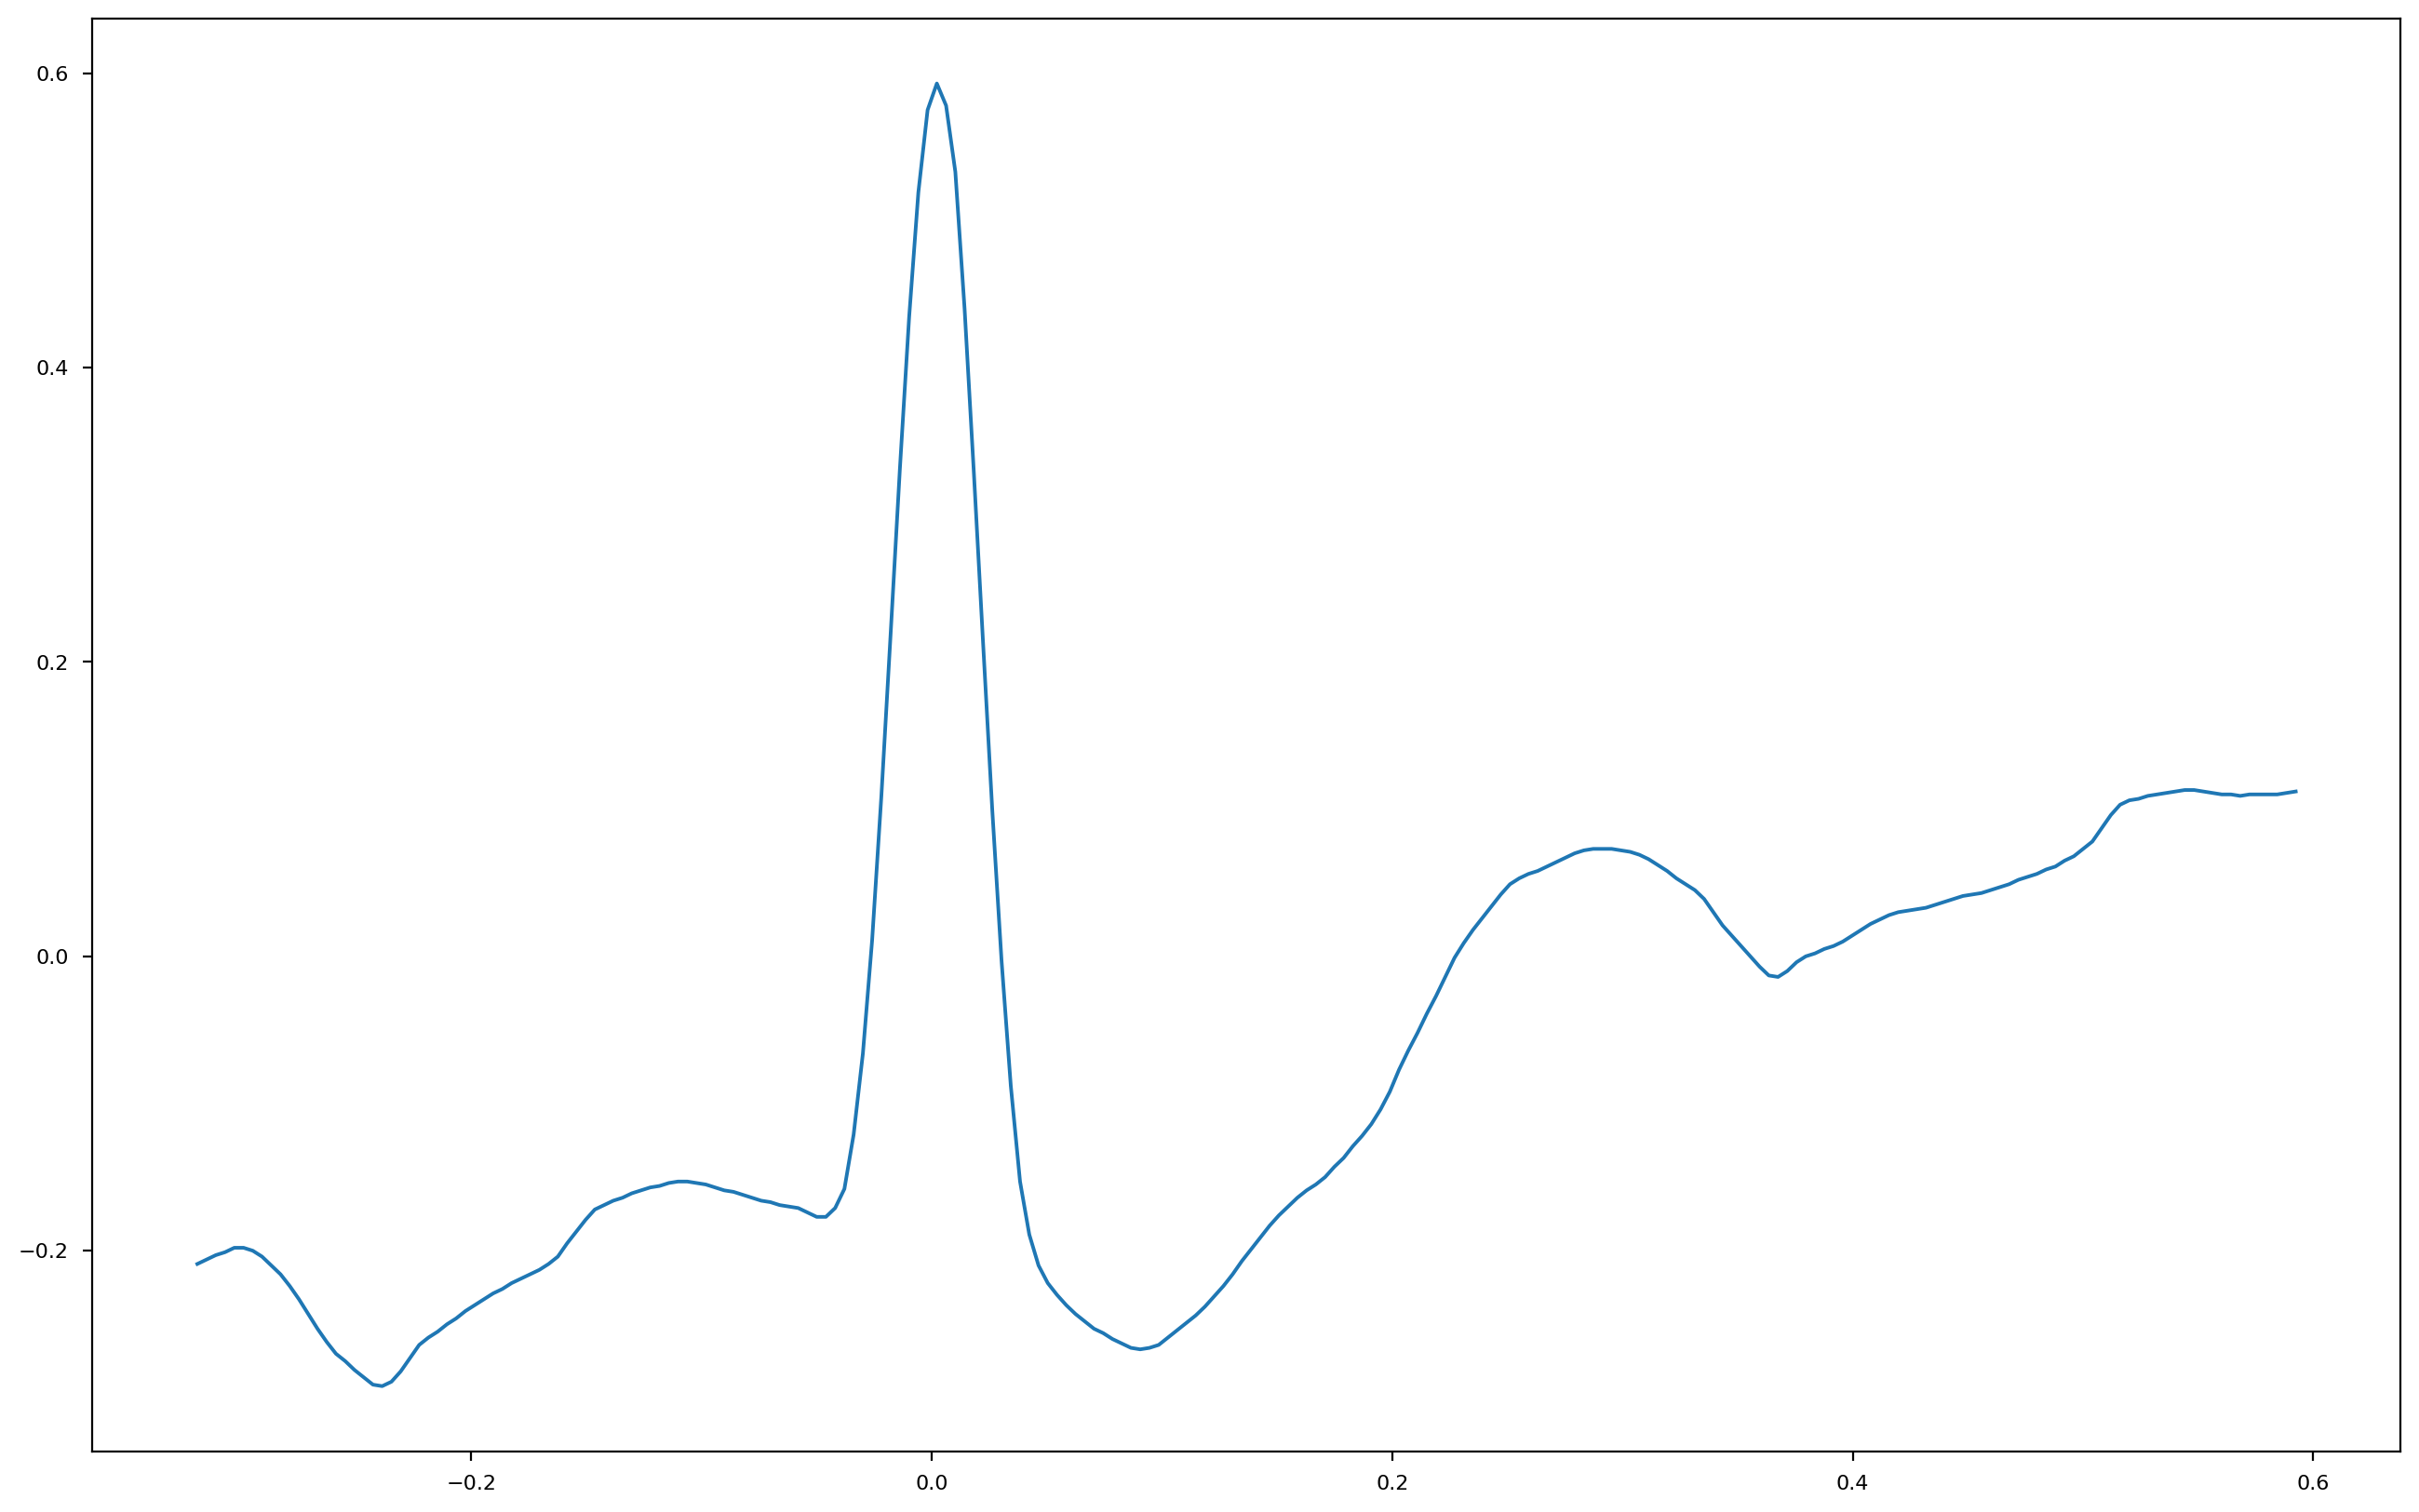

In [66]:
indevidual_heartbit = epochs["1"]["Signal"]
plt.plot(indevidual_heartbit)

In [67]:
images = signal_to_images(ecg_signal)
len(images)

39

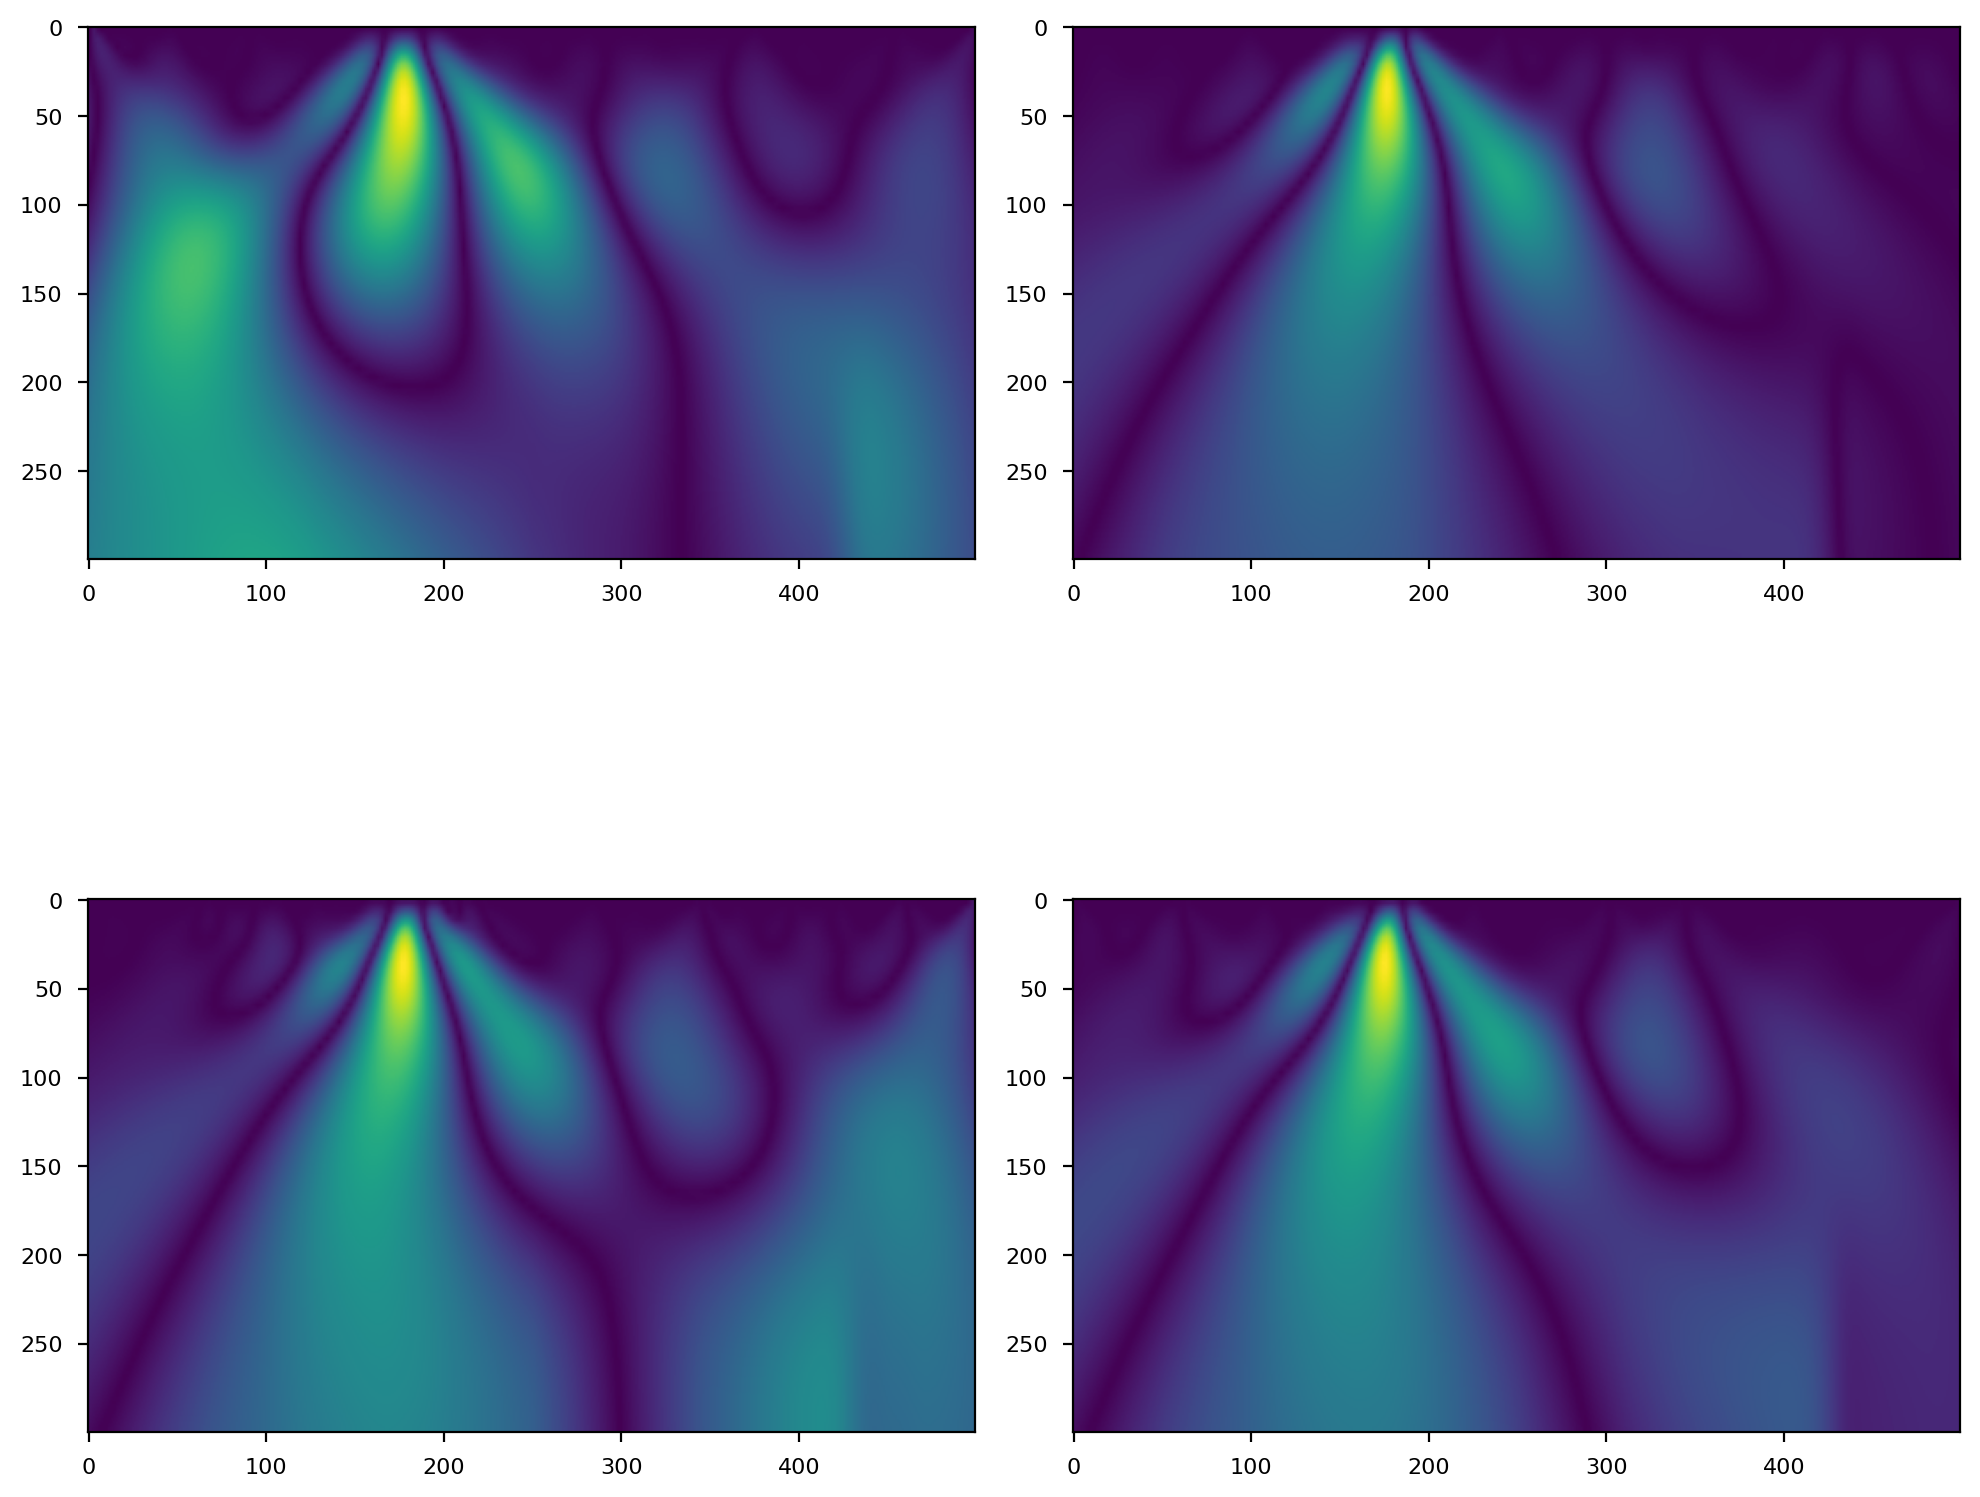

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
for i in range(4):
    ax[i].imshow(images[4 * i])
plt.tight_layout()